In [1]:
%pylab inline
import json
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
import sklearn
import pandas as pd
from typing import Tuple
from typing import List
import numpy as np

# dataset1 = pd.read_csv('data_till_29_oct.csv')
# dataset2 = pd.read_csv('data_after_29_oct.csv')
# # convert to arrays from strings
# def assign_task_name(string):
#     if 'lumosity'in string:
#         return 'cognitive'
#     if 'Game' in string:
#         return 'cognitive'
#     if 'head'in string:
#         return 'baseline'
#     if 'nback' in string:
#         return 'cognitive'
#     if 'Baseline' in string:
#         return'baseline'
#     else:
#         return 'cognitive'

# dataset=dataset1.append(dataset2)
# dataset.eeg = dataset.eeg.map(json.loads)
# dataset['date']=dataset['date'].apply(lambda x:x+'-2017')
# dataset['task']=dataset['activity'].apply(lambda x :assign_task_name(x))
# dataset.to_csv('all_data_labelled.csv',index=False)
# dataset['date']=pd.to_datetime(dataset['date'], format='%d-%m-%Y')
# dataset.to_csv('all_data_labelled.csv',index=False)

Populating the interactive namespace from numpy and matplotlib


/Users/sanaiqbal/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
dataset = pd.read_csv('all_data_labelled.csv')
dataset.eeg = dataset.eeg.map(json.loads)
dataset['date']=pd.to_datetime(dataset['date'])

dataset=dataset.sort_values(by='date')


# add phase info


In [28]:
def get_phase(date):
    date1 = datetime.datetime.strptime('2017-10-10', "%Y-%m-%d")
    days=(date-date1).days
    
    if days<0:
        days=30+days
    if days>30:
        days=days-30
        
    return days

dataset['phase_distance']=dataset['date'].apply(lambda x:get_phase(x))
dataset['phase_no']=pd.cut(dataset['phase_distance'],bins=[-1,5,14,15,31],labels=[1,2,3,4])

In [31]:
dataset.head()


eeg                activity  \
21  [28, -41, 38, 66, 27, 115, 90, 75, 38, 58, 76,...       headspaceSession1   
12  [99, 74, 83, 82, 55, 59, 71, 29, -54, 58, 33, ...  lumosityTrainOfThought   
22  [20, 50, 73, 39, 18, 45, 24, 53, 58, 57, 18, 1...  headspaceProductivity1   
16  [-74, -130, -195, -93, -101, -291, -129, -81, ...    lumosity CoffeeShop1   
15  [117, 96, 69, 57, 53, 48, 48, 48, 45, 45, 45, ...         lumosity color1   

         date      time                                           metadata  \
21 2017-10-08  13-12-43  {'metadata': {'Feeling': 'OK', 'Time': '28-10_...   
12 2017-10-08  13-12-43  {'metadata': {'Feeling': 'OK', 'Time': '28-10_...   
22 2017-10-09  13-12-43  {'metadata': {'Feeling': 'OK', 'Time': '28-10_...   
16 2017-10-09  13-12-43  {'metadata': {'Feeling': 'OK', 'Time': '28-10_...   
15 2017-10-09  13-12-43  {'metadata': {'Feeling': 'OK', 'Time': '28-10_...   

         task                                            segment  \
21   baseline  [2366336025.0, 1313743.09316, 793617.273739, 4...   
12  cognitive  [2225103241.0, 3136423.10176, 25731170.3382, 6...   
22   baseline  [2500800064.0, 8629896.87478, 26386848.7255, 6...   
16  cognitive  [2298914809.0, 376544.790586, 8292235.34078, 2...   
15  cognitive  [820650609.0, 61308462.879, 348331539.173, 528...   

    phase_distance phase_no  
21              28        4  
12              28        4  
22              29        4  
16              29        4  
15              29        4

In [4]:
lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))

rm=[i for i, j in enumerate(lengths_of_eeg) if j == 0]
dataset=dataset.drop(dataset.index[[rm]])
# min(lengths_of_eeg)

In [5]:
lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
min(lengths_of_eeg)

# rm=[i for i, j in enumerate(lengths_of_eeg) if j == 0]
# rm

1180

In [6]:
# dataset['phase_distance']

In [7]:
# # drop any eeg of len 0
# dataset=dataset.drop(dataset.index[[rm]])
# lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
# min(lengths_of_eeg)


In [8]:

def partition(lst, size):
    
    """split eeg list into partitions of size 'size"""
    
    if len(lst)<size:
        return []
    else:
        lists=[]

        for i  in range(0, len(lst), size):
            if len(lst[i:i+size])==size:
                lists.append(lst[i:i+size])

        return lists
    
    
from numpy import dot
from numpy.linalg import norm

def cosine_similarity(a,b):
    return dot(a, b)/(norm(a)*norm(b))
                      
partition([1,2,3,4,5,6,7,8,9,10],9)      


[[1, 2, 3, 4, 5, 6, 7, 8, 9]]

In [9]:
# partition each  eeg entry into equal length lists
dataset['eeg']=dataset['eeg'].apply(lambda x:partition(x,1024))

In [10]:
#dataset['eeg'].apply(lambda x:len(x))

In [11]:
def to_power_spectrum (raw_readings):
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    
    '''
    
    sampling_rate=len(raw_readings)
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size,d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = pd.DataFrame({
        'frequency (Hz)': freqs,
        'magnitude': ps,
    })
    return power_spectrum
def bandpass (
    power_spec: pd.Series,
    low_cutoff: float,
    high_cutoff: float,)-> pd.Series:
    
    '''"zooming in" or "cropping" to these frequencies.'''
    
    return power_spec[(power_spec['frequency (Hz)'] > low_cutoff) & 
                      (power_spec['frequency (Hz)'] < high_cutoff)]


In [12]:
def pickup_randomchunk(raw_reading_chunks):
    '''this function picks a random chunk from the partitioned signal'''
    index = np.random.randint(len(raw_reading_chunks))
#     print(raw_reading_chunks [index])
    return raw_reading_chunks [index] 


def plot_eeg(group,date):
    colormap=['red','green','black','blue','aqua','pink']
    tasklist={'cognitive':'red','baseline':'blue'}
    counter=0
    plt.figure(figsize=(20,5),dpi=150)
    for i, row in group.iterrows():
#         print(row['eeg'])
#         print(i)
        plt.plot(row['eeg'][1], linestyle='-',linewidth = 1,color= tasklist[row['task']])
        counter+=1
    plt.title('RAW-EEG for'+date)
    plt.legend()
    plt.show()
        
        
        
def plot_fft_eeg(group,date):
    colormap=['red','green','black','blue','aqua','pink']
    tasklist={'cognitive':1,'baseline':2}
    tasklist={'cognitive':'red','baseline':'blue'}
    counter=0
    plt.figure(figsize=(20,5),dpi=150)
    plt.axvline(x=0.5,linewidth = 1.5)
    plt.text(0.5,0,'delta',rotation=90)
    plt.axvline(x=4,linewidth = 1.5)
    plt.text(4,1,'theta',rotation=90)
    plt.axvline(x=8,linewidth = 1.5)
    plt.text(8,1,'alpha',rotation=90)
    plt.axvline(x=13,linewidth = 1.5)
    plt.text(13,1,'beta',rotation=90)
    plt.axvline(x=30,linewidth = 1.5)
    plt.text(30,1,'gamma',rotation=90)
   
    for i, row in group.iterrows():
        if len(row['eeg'])>0:
# put condition to get second list of each eeg -inserting 1 in >>>row['eeg'][1]
        
            power_spec=to_power_spectrum(pickup_randomchunk(row['eeg']))
       
            plt.plot(bandpass(power_spec,0,30),color=tasklist[row['task']],linewidth = 1.5, label=row['task'])
        counter+=1
    plt.title(' FFT PLOT for'+ str(date))
    plt.legend()
    plt.show()
        

Date 2017-10-08 00:00:00


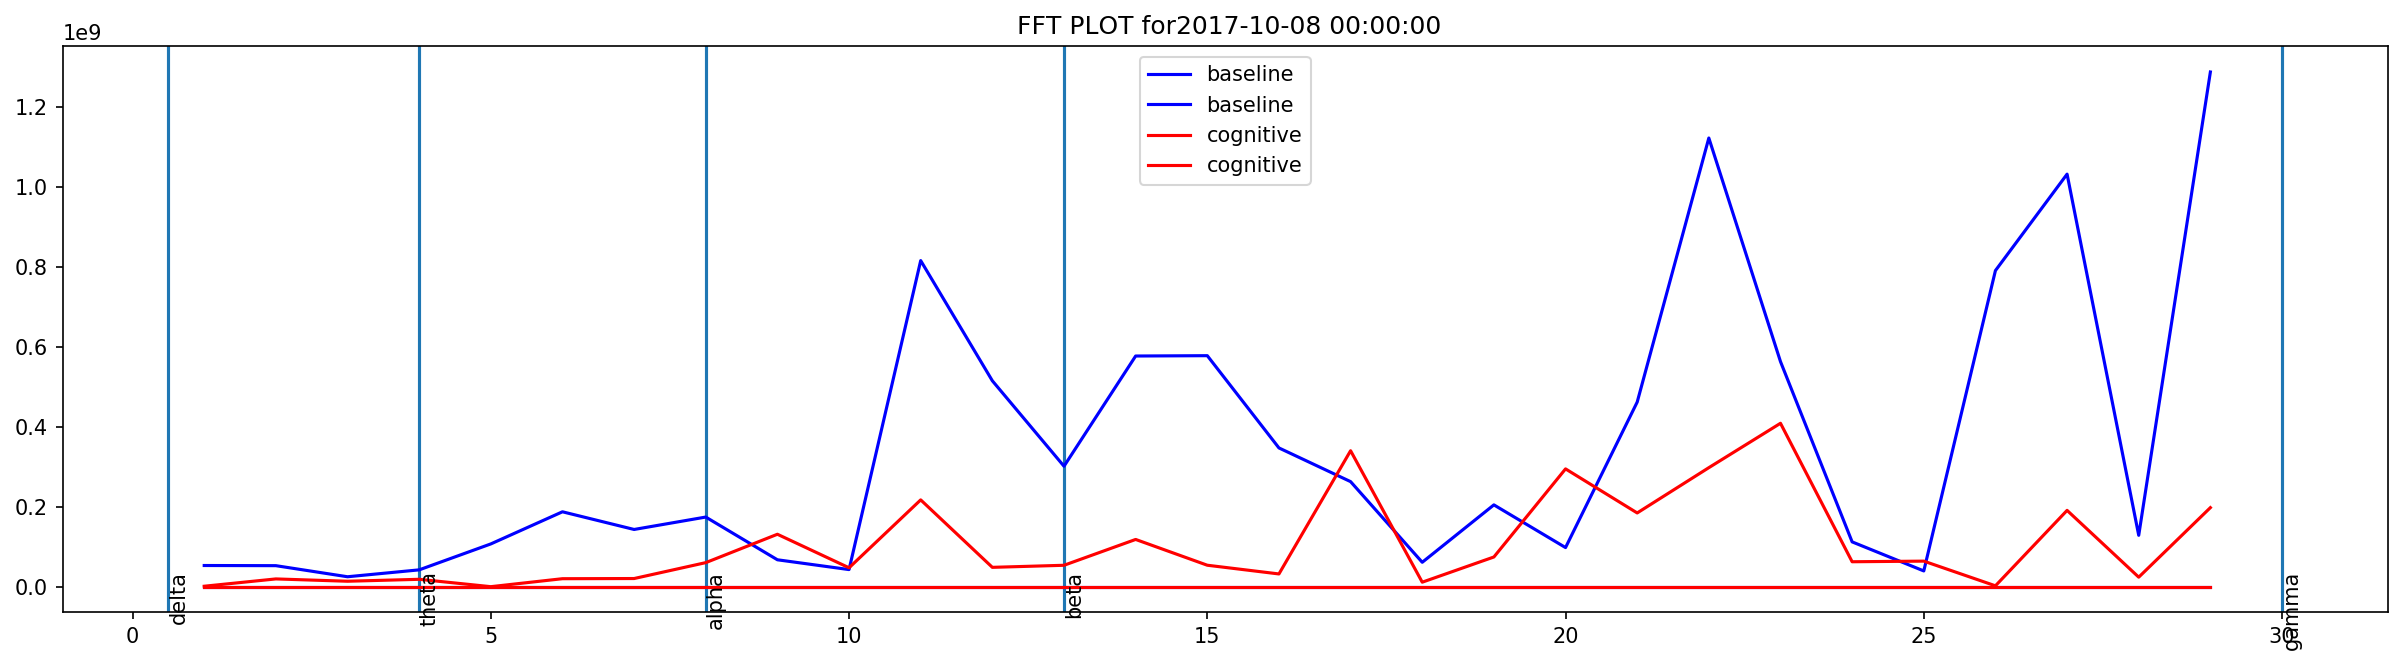

Date 2017-10-09 00:00:00


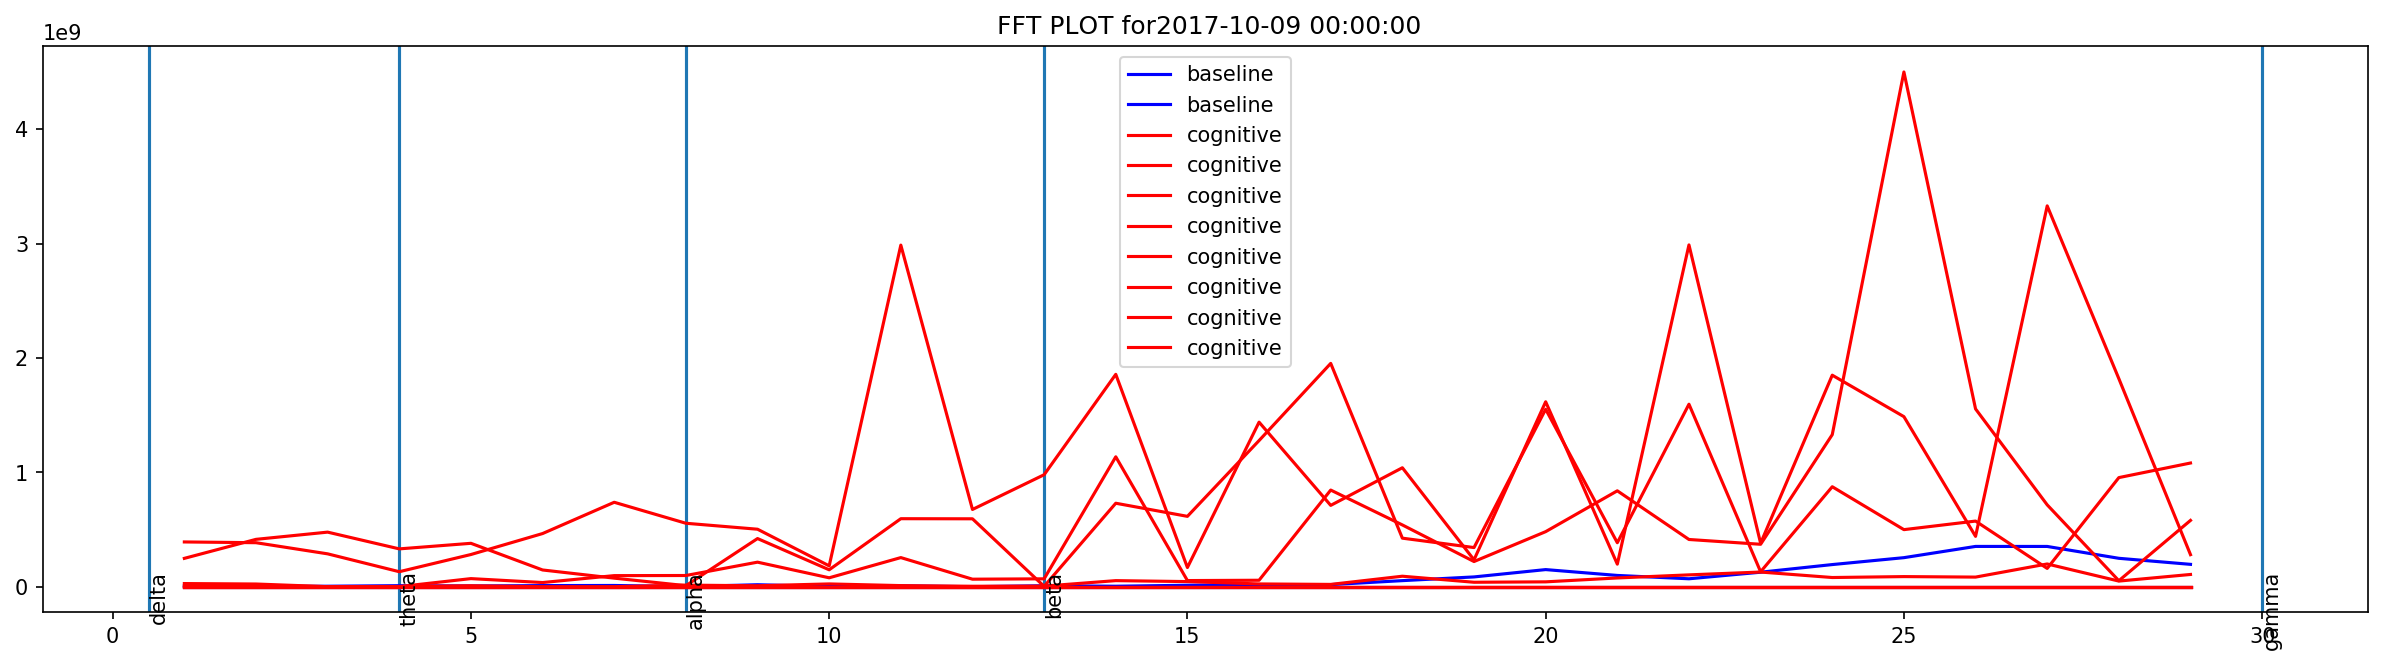

Date 2017-10-10 00:00:00


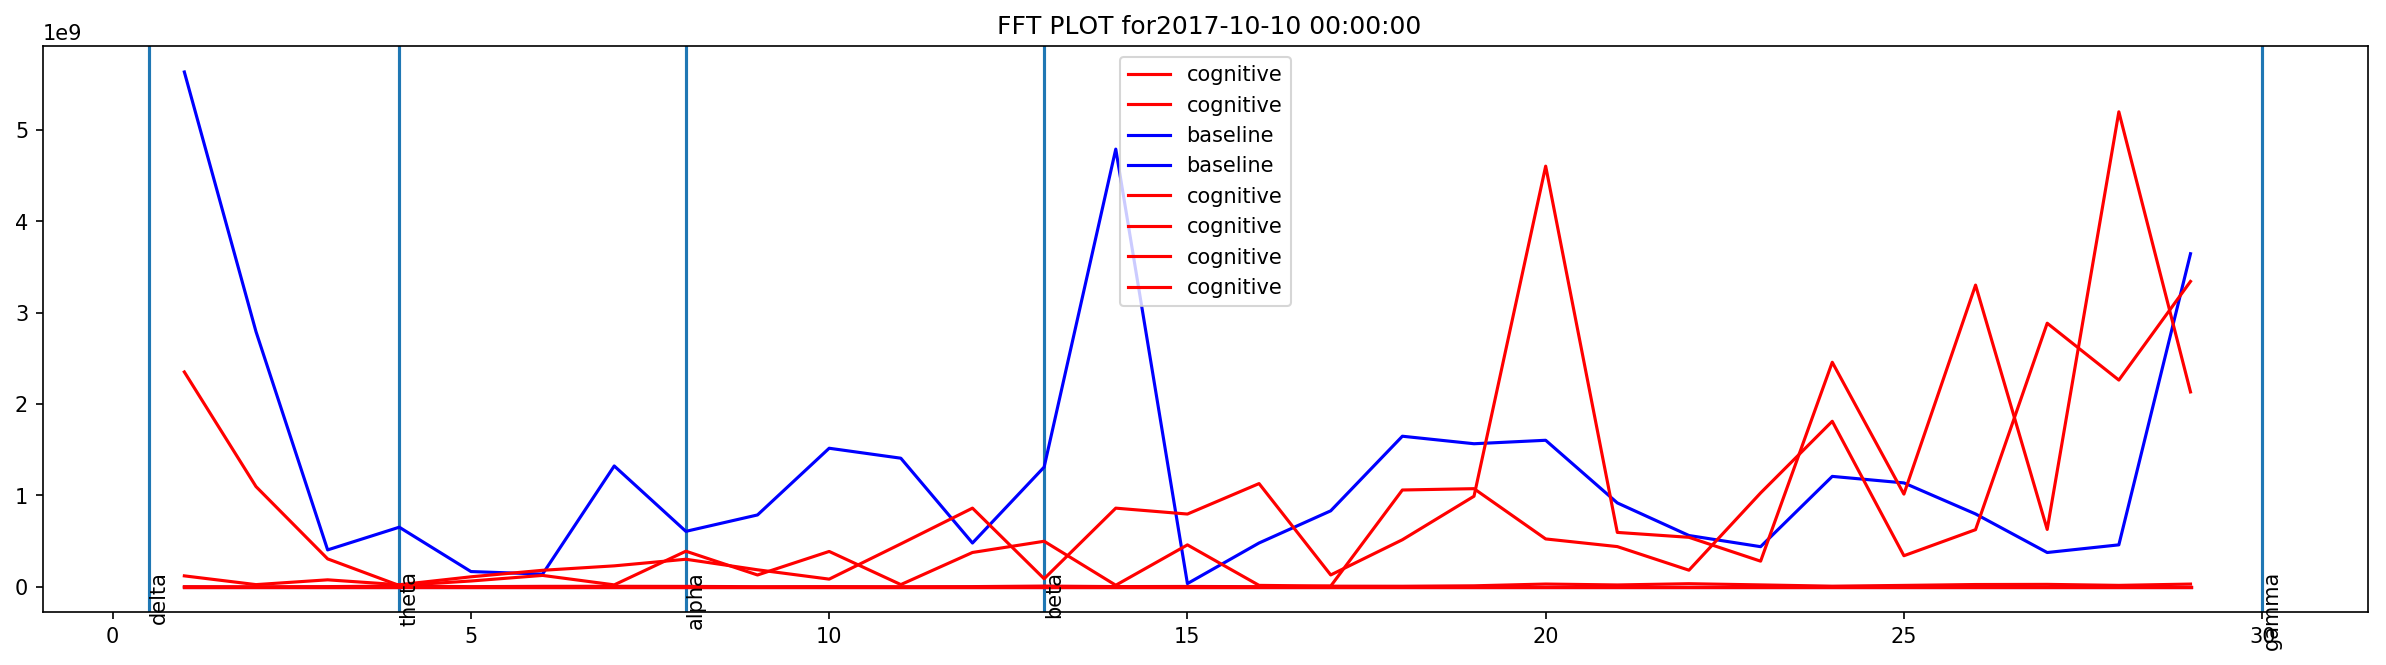

Date 2017-10-11 00:00:00


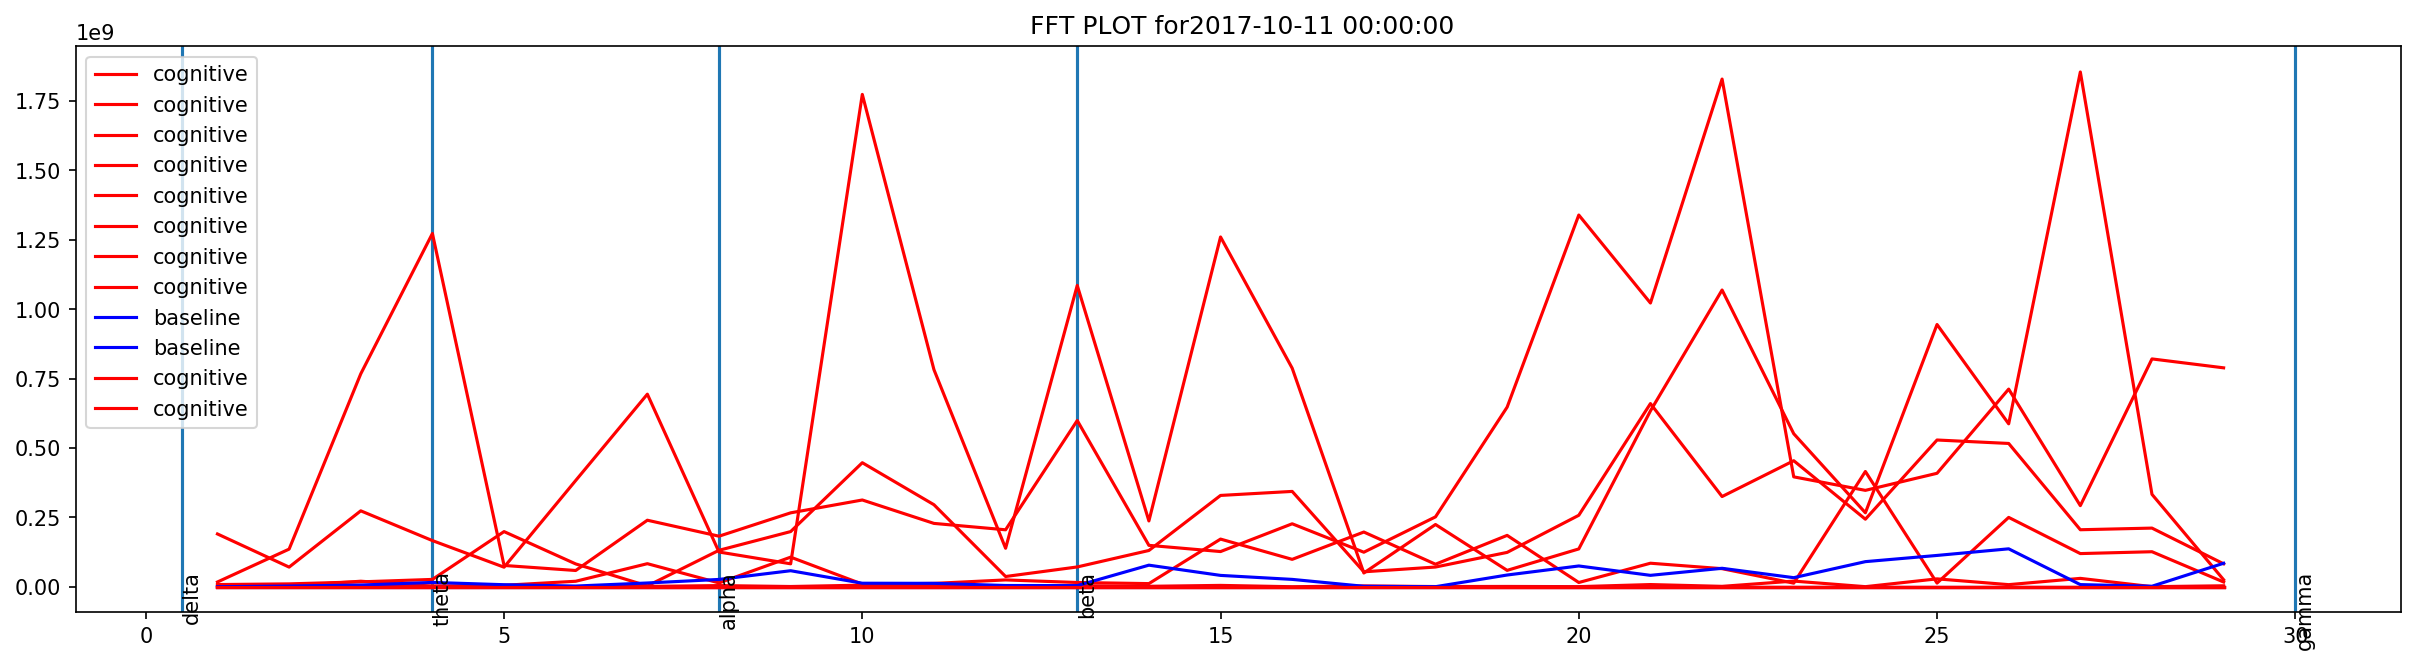

Date 2017-10-12 00:00:00


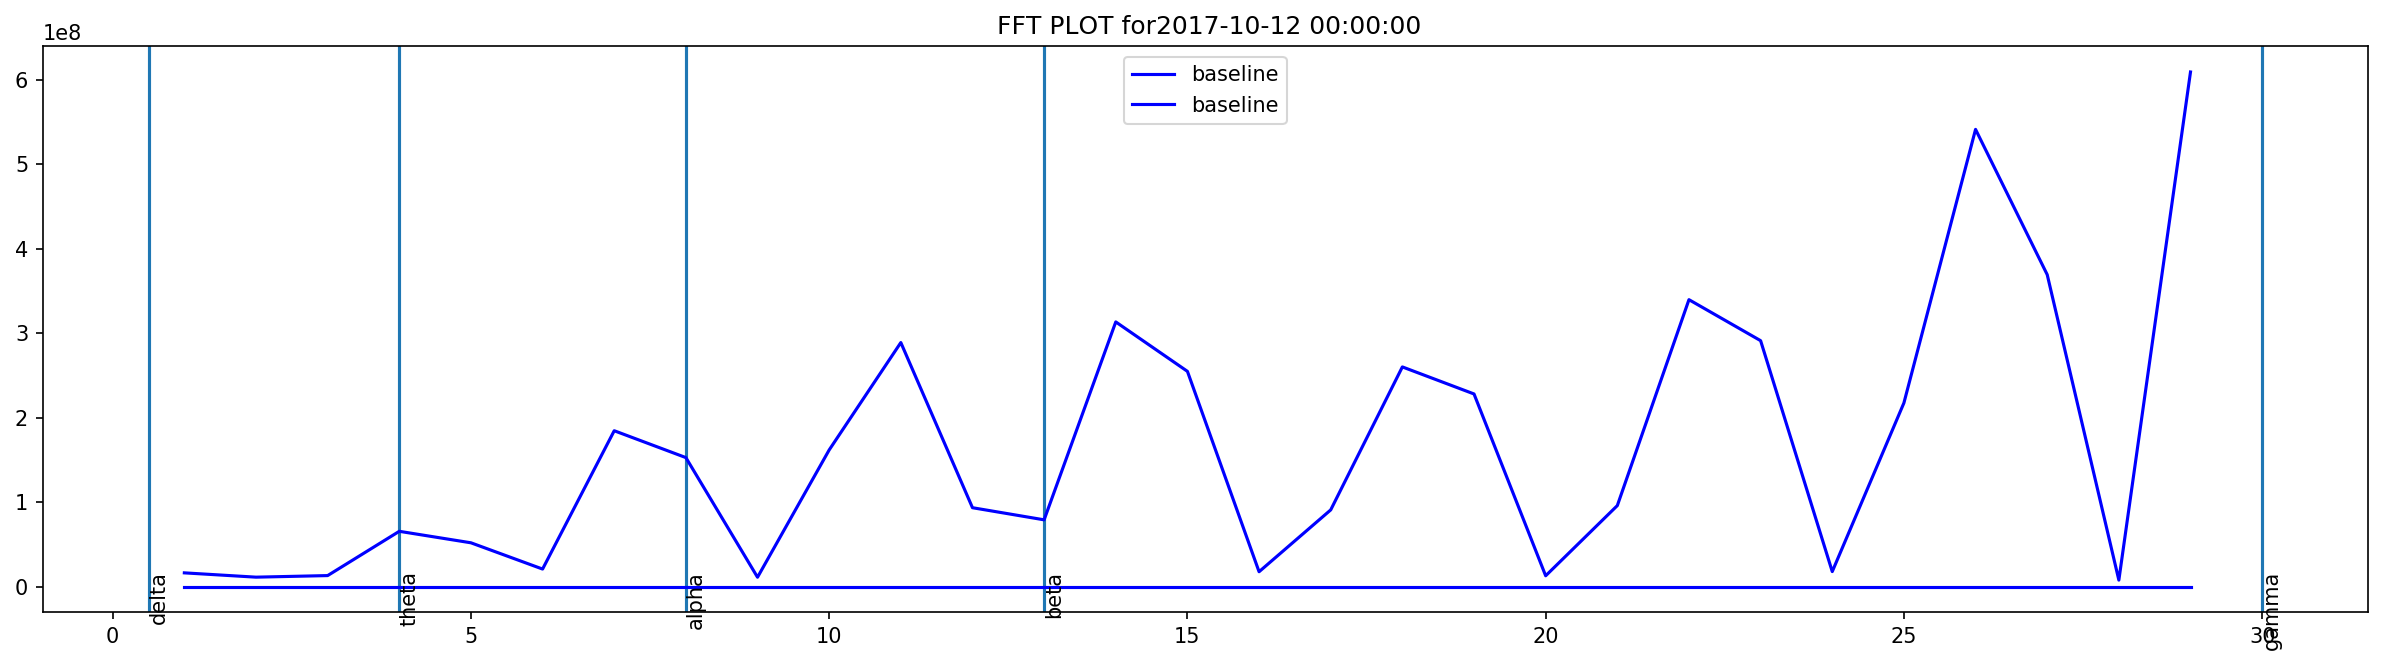

Date 2017-10-13 00:00:00


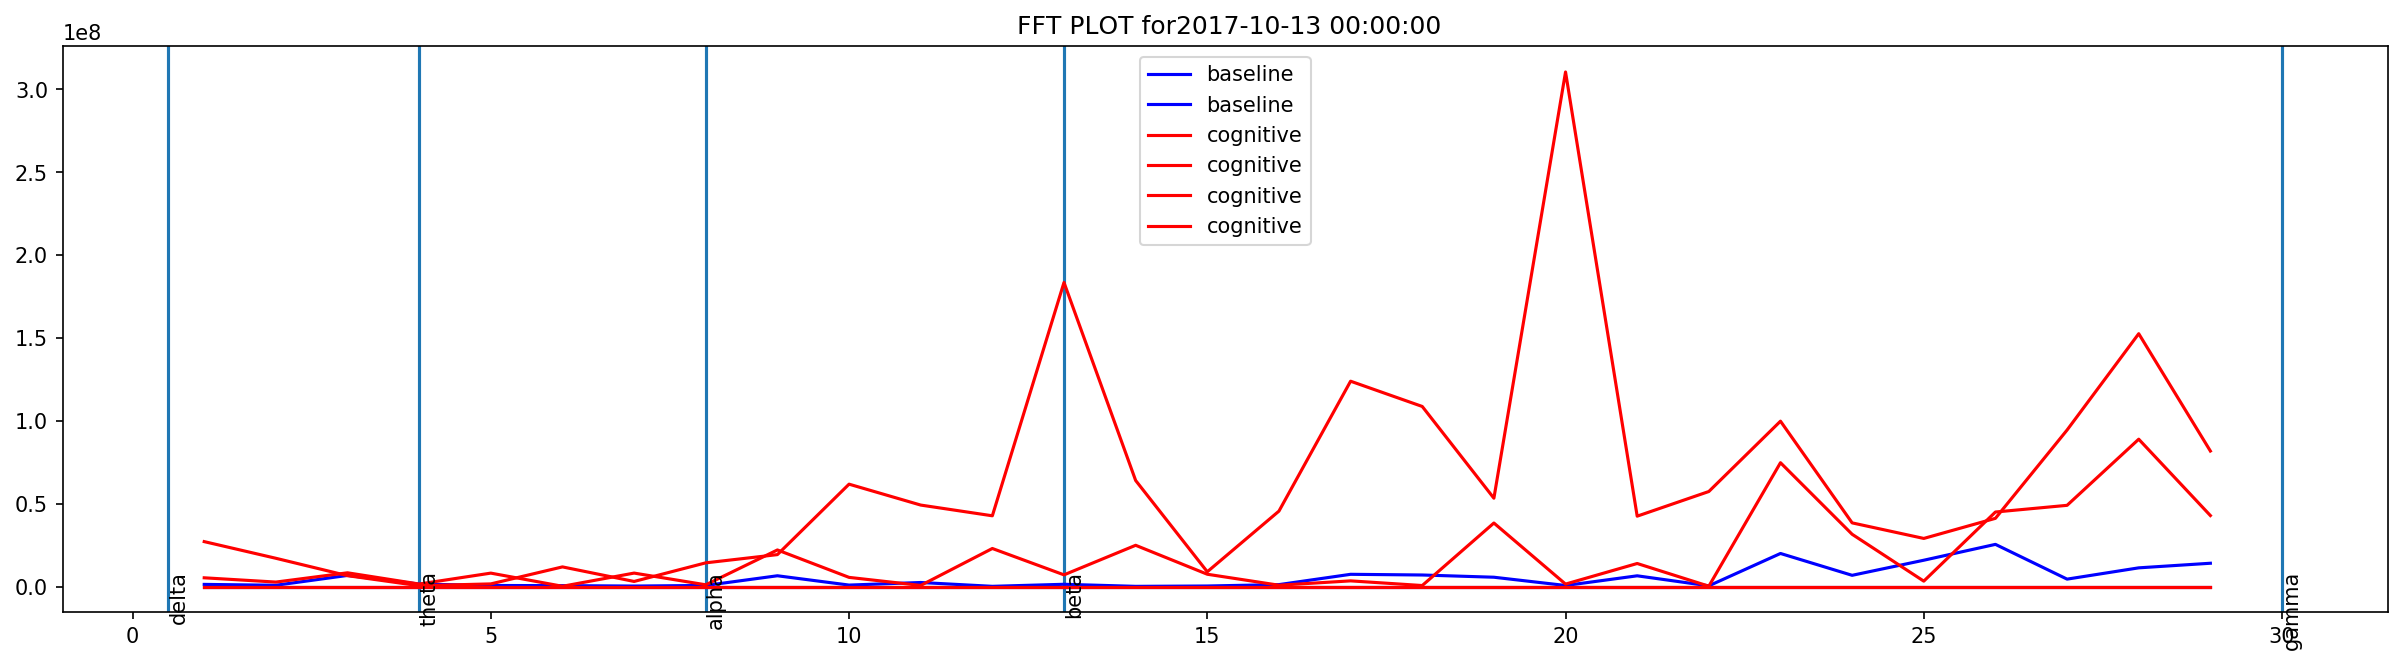

Date 2017-10-16 00:00:00


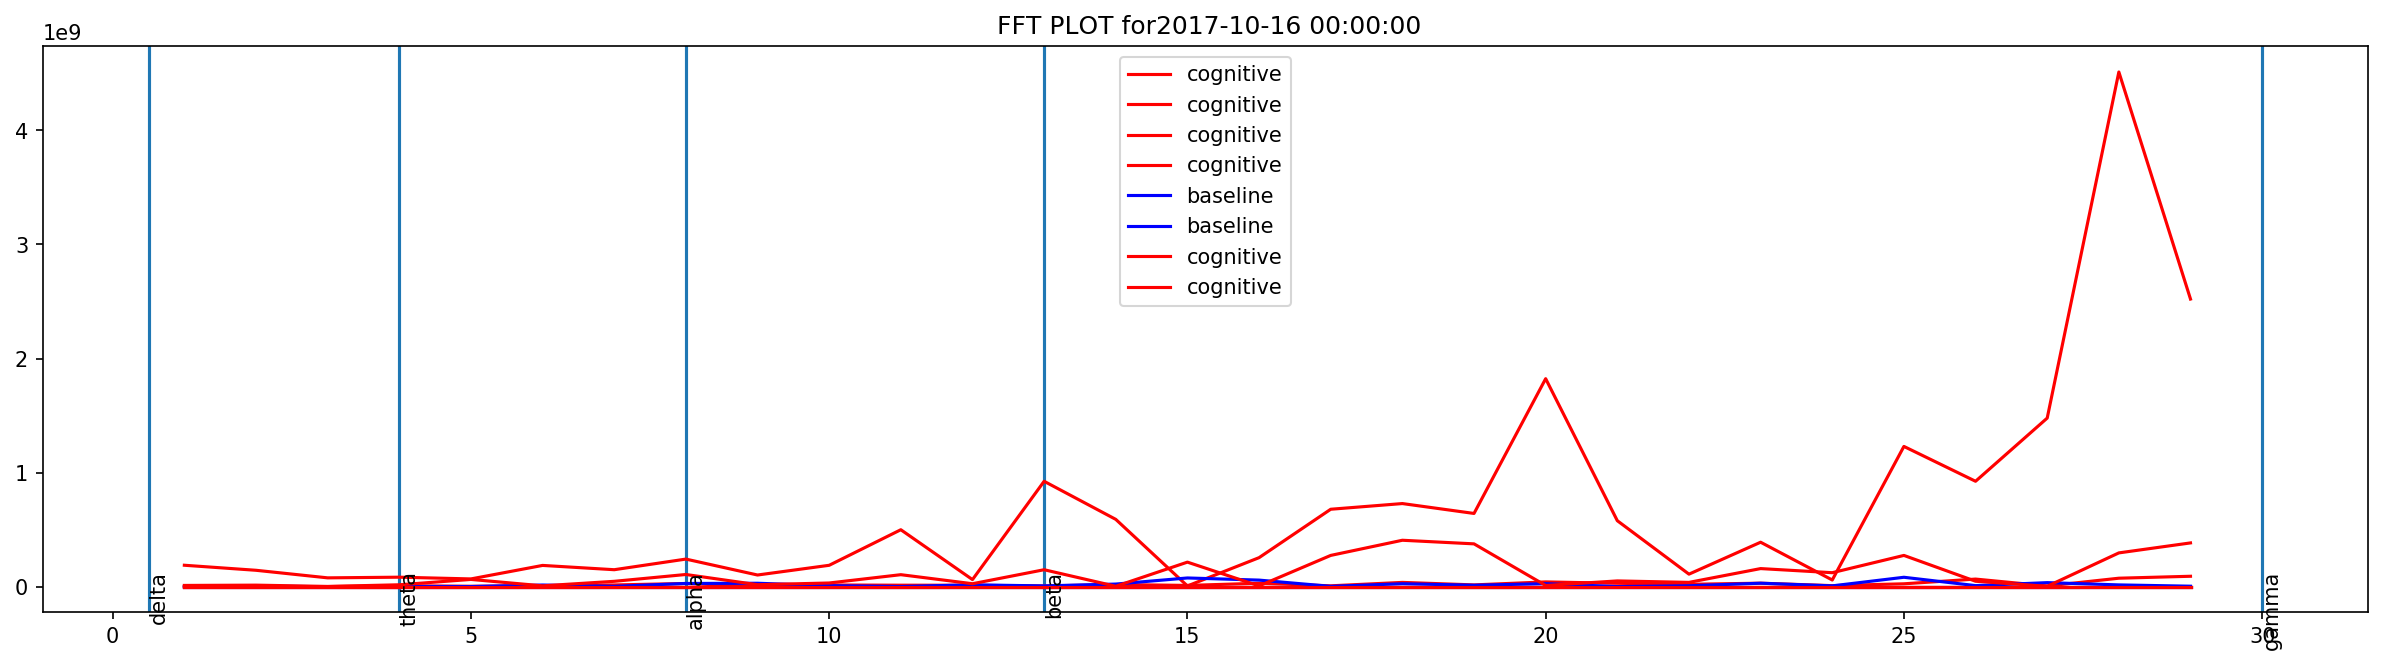

Date 2017-10-18 00:00:00


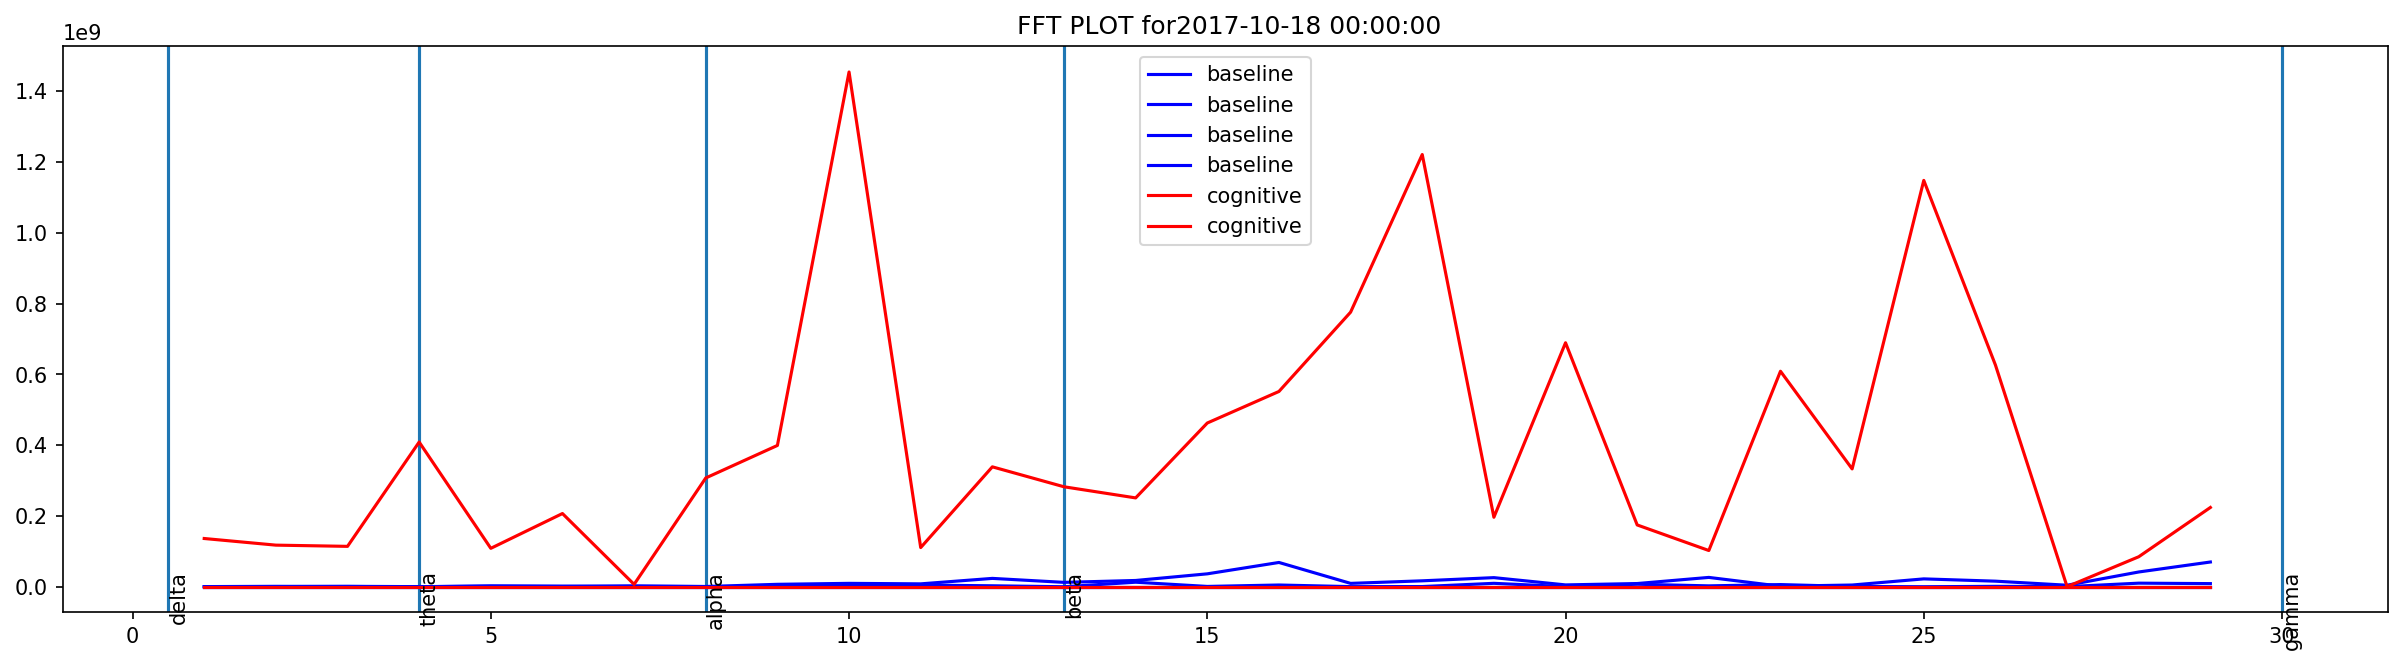

Date 2017-10-20 00:00:00


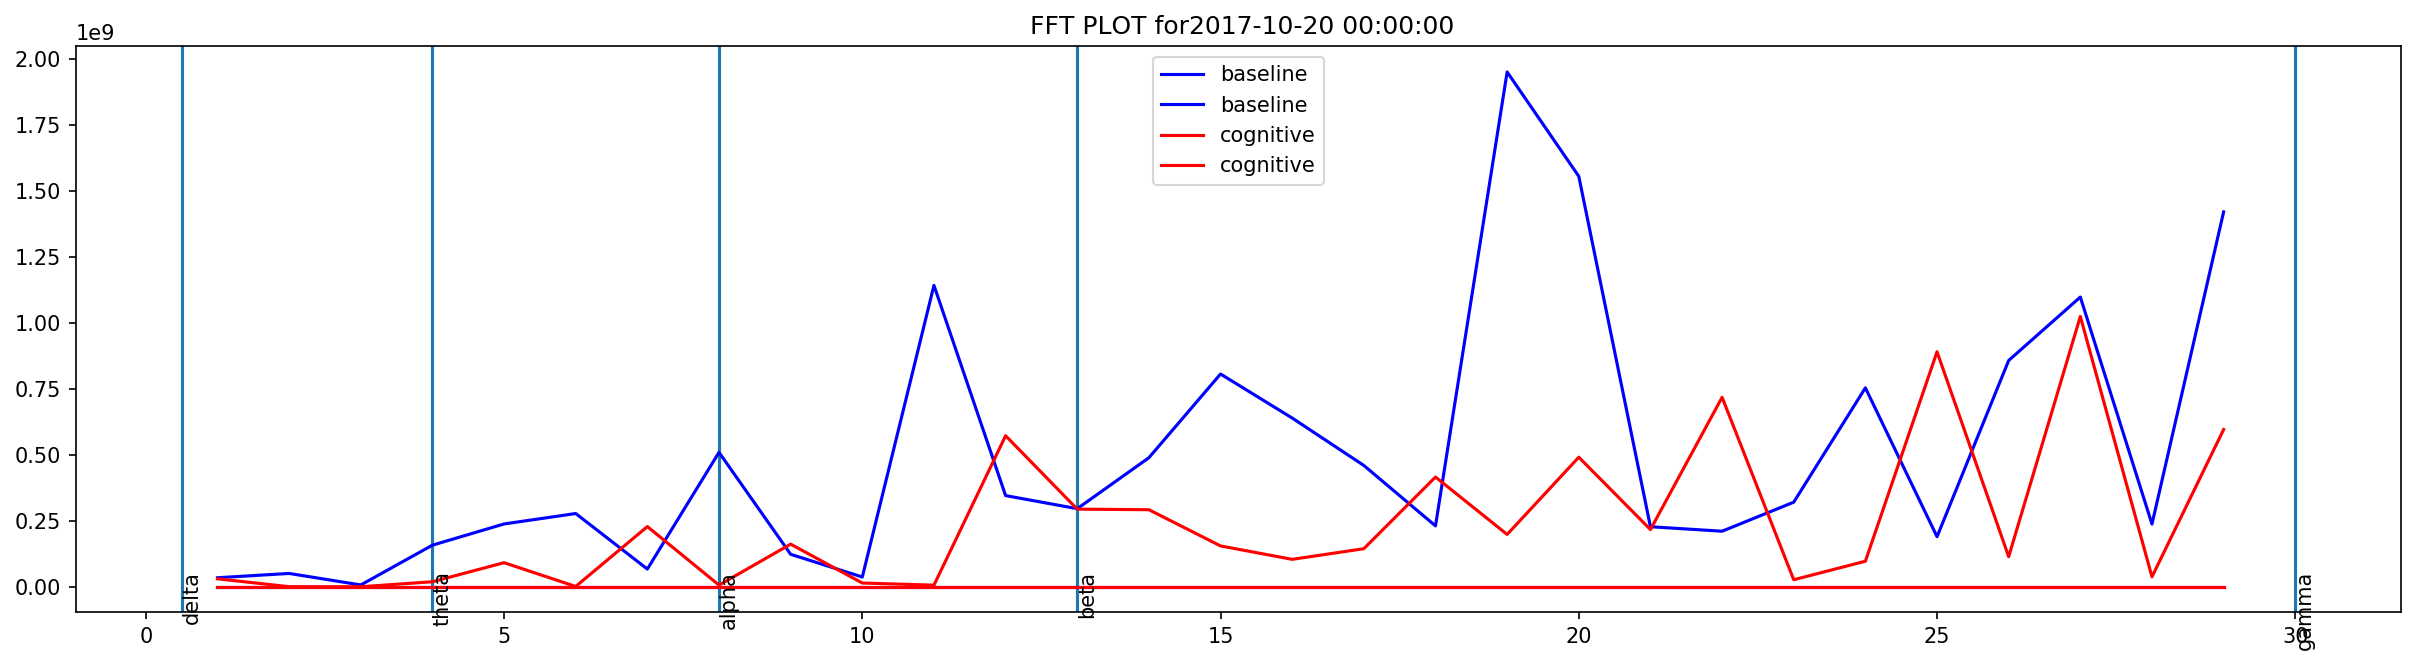

Date 2017-10-22 00:00:00


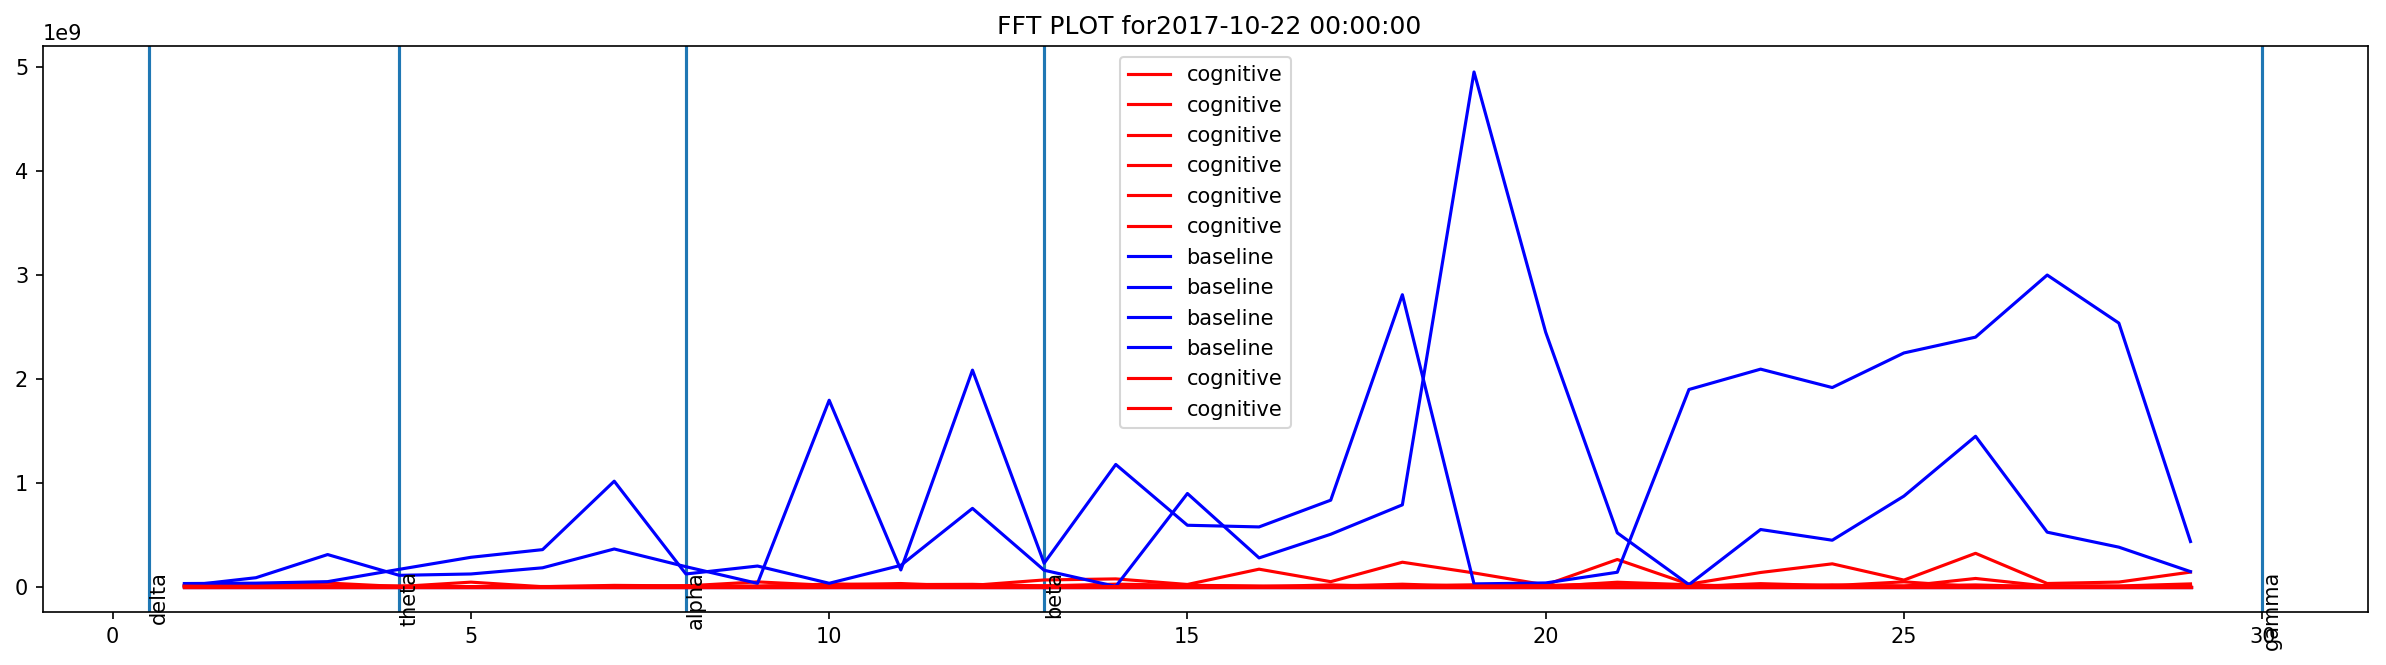

Date 2017-10-23 00:00:00


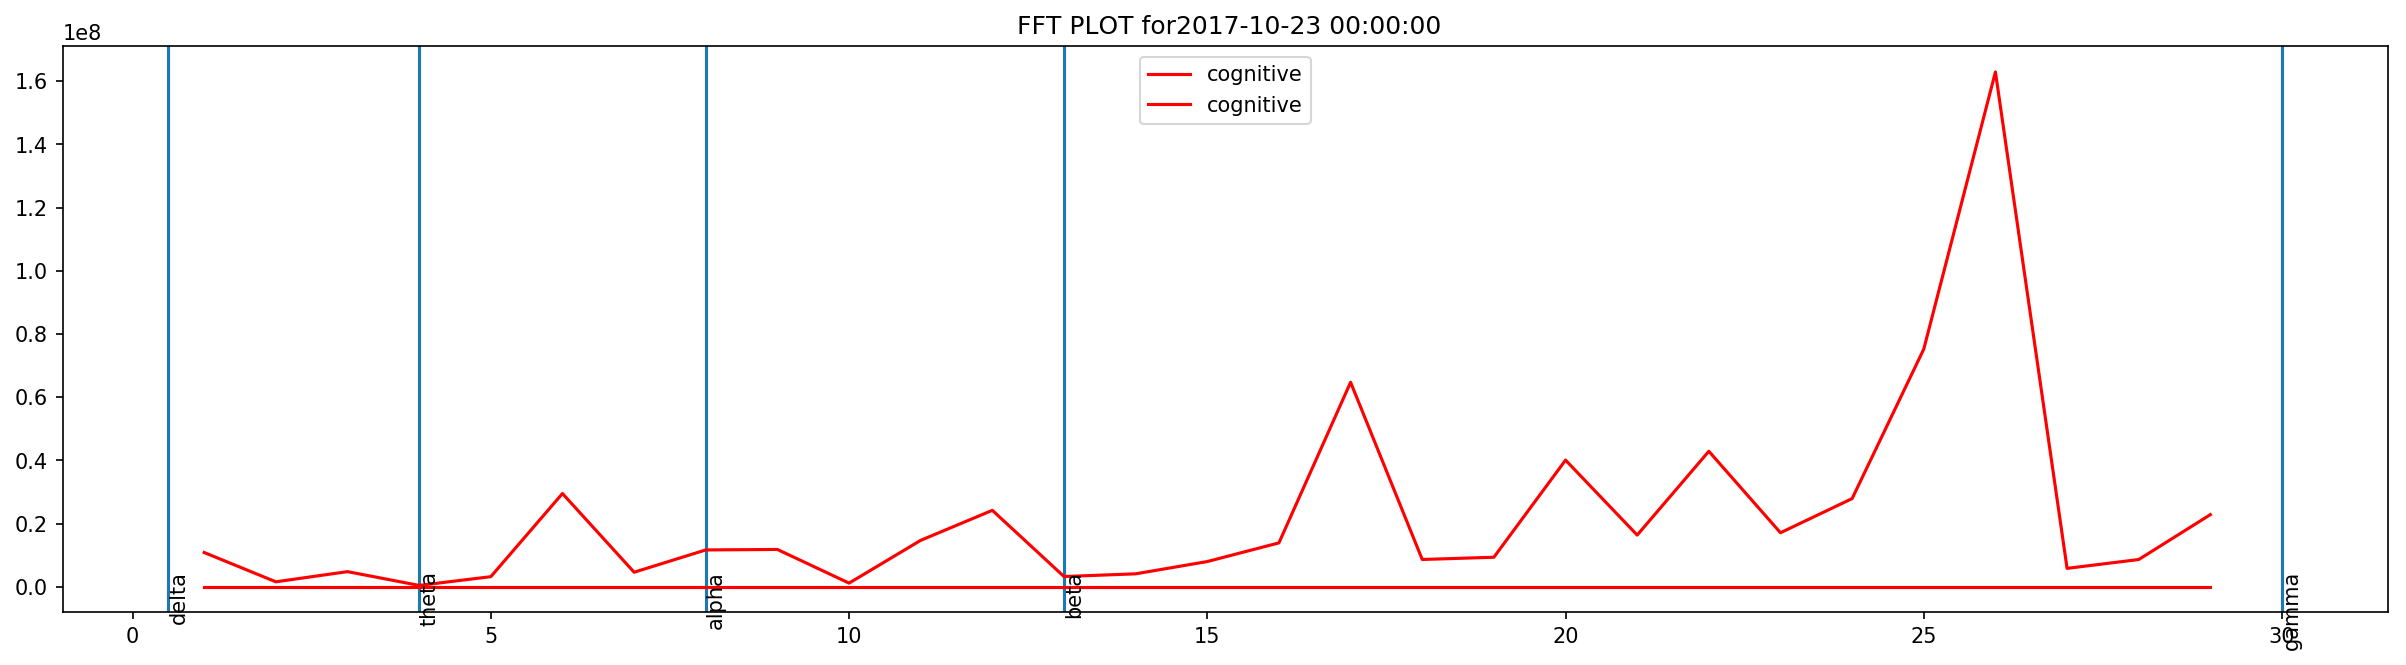

Date 2017-10-24 00:00:00


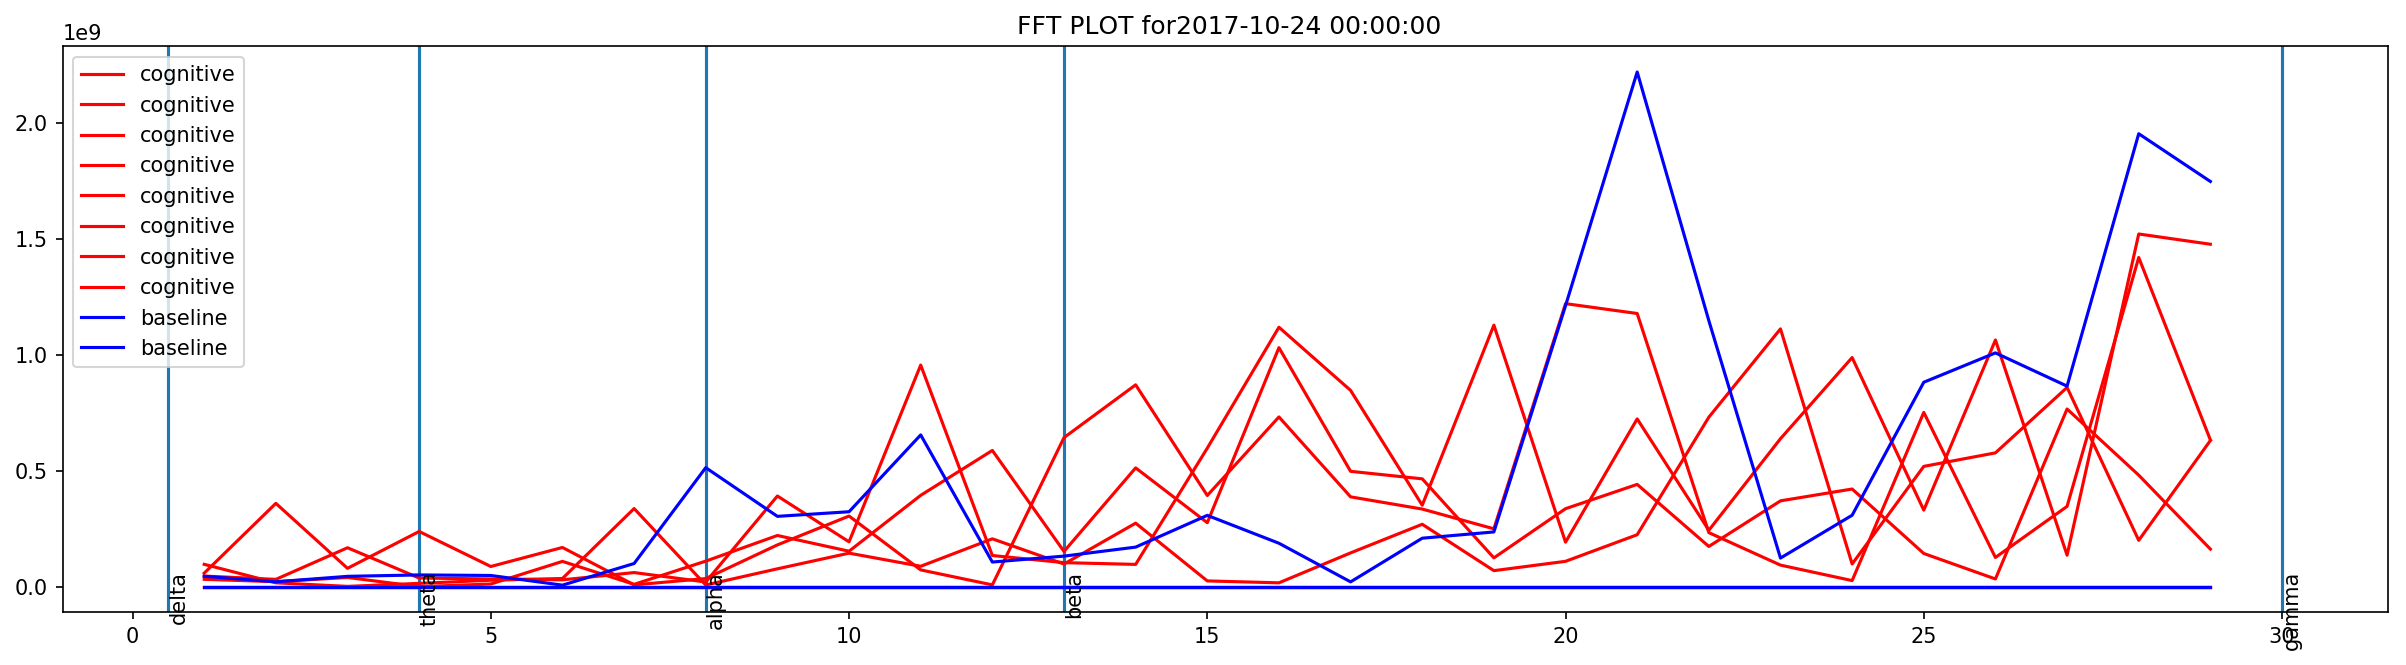

Date 2017-10-27 00:00:00


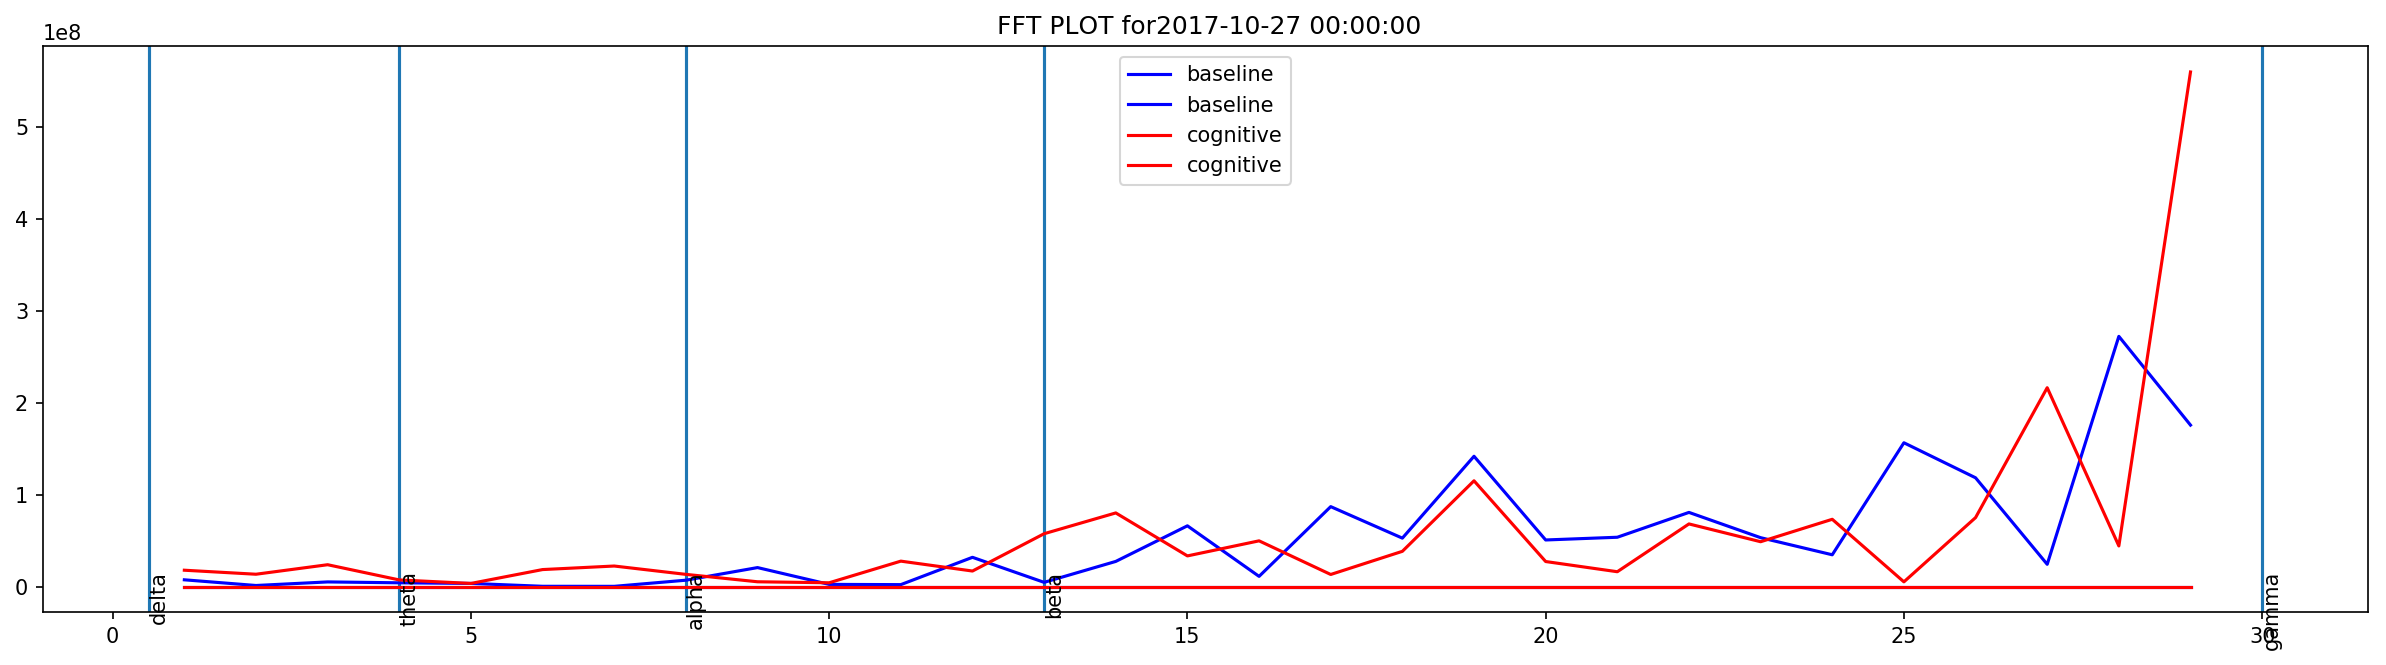

Date 2017-10-28 00:00:00


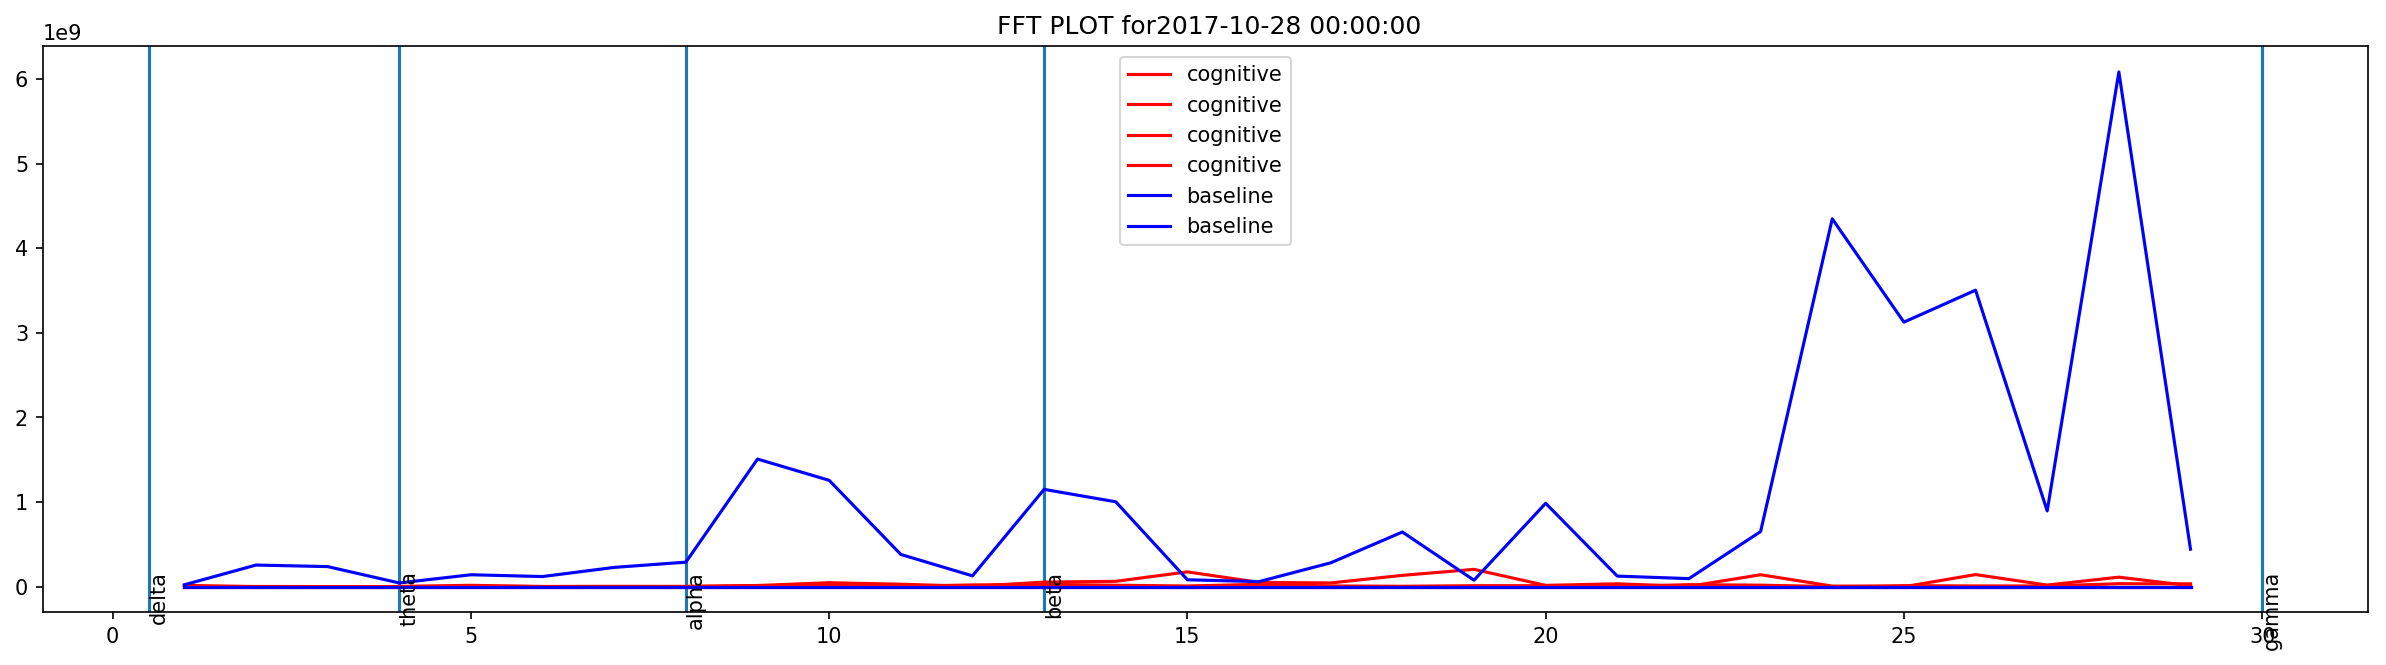

Date 2017-10-29 00:00:00


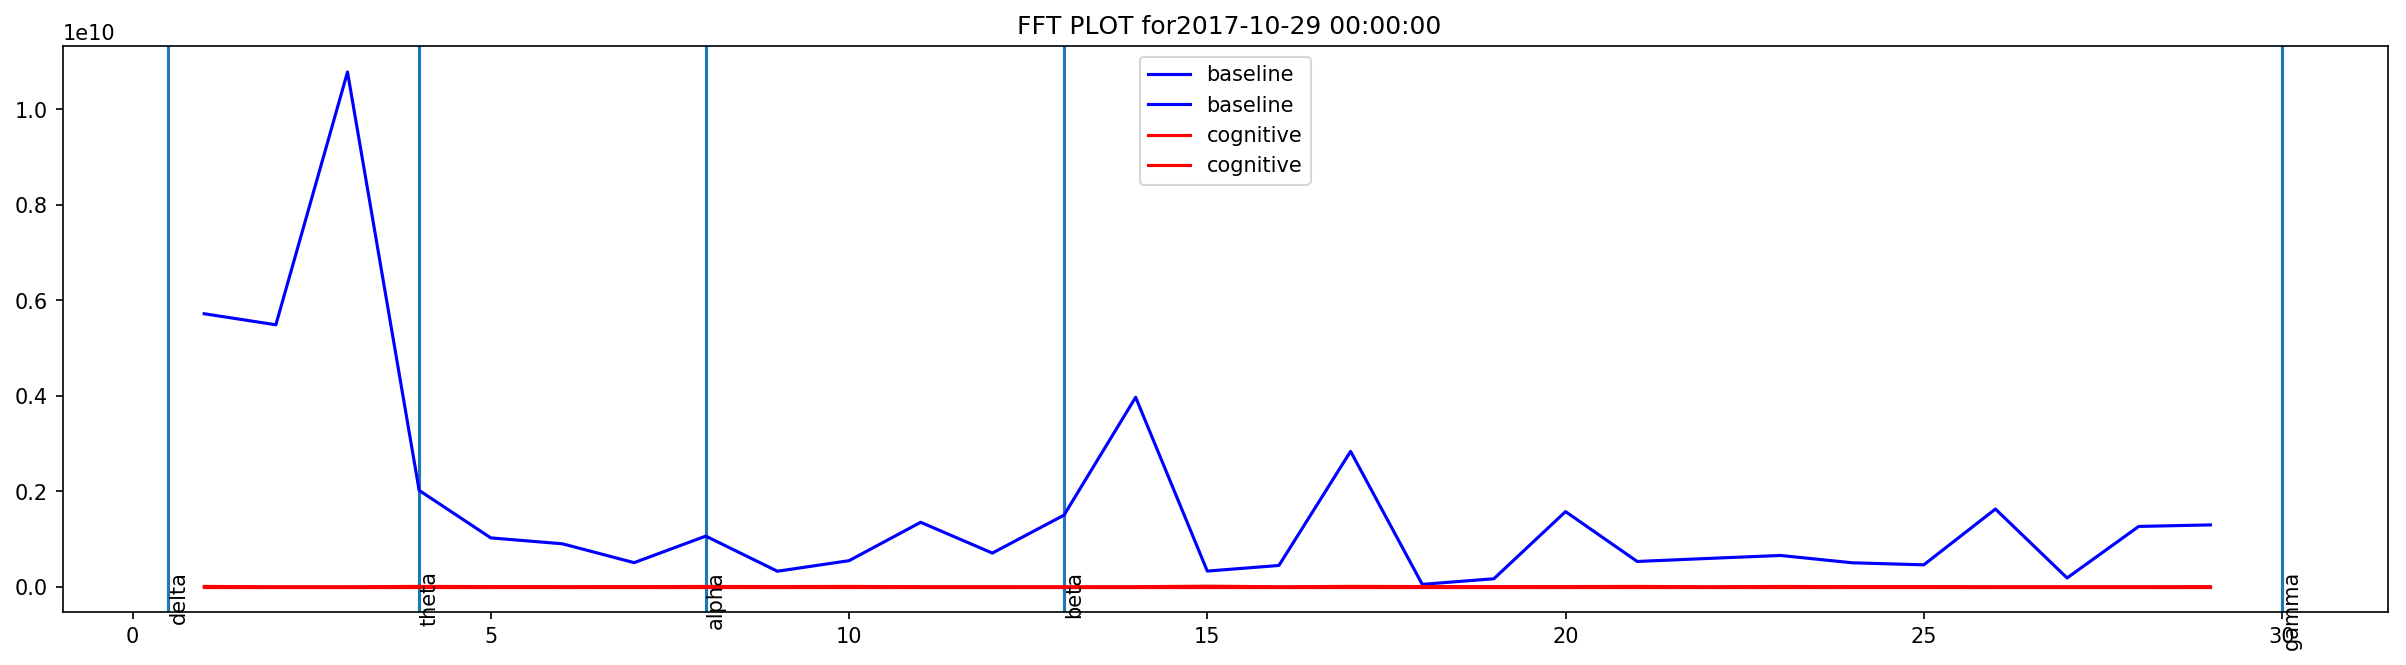

Date 2017-10-30 00:00:00


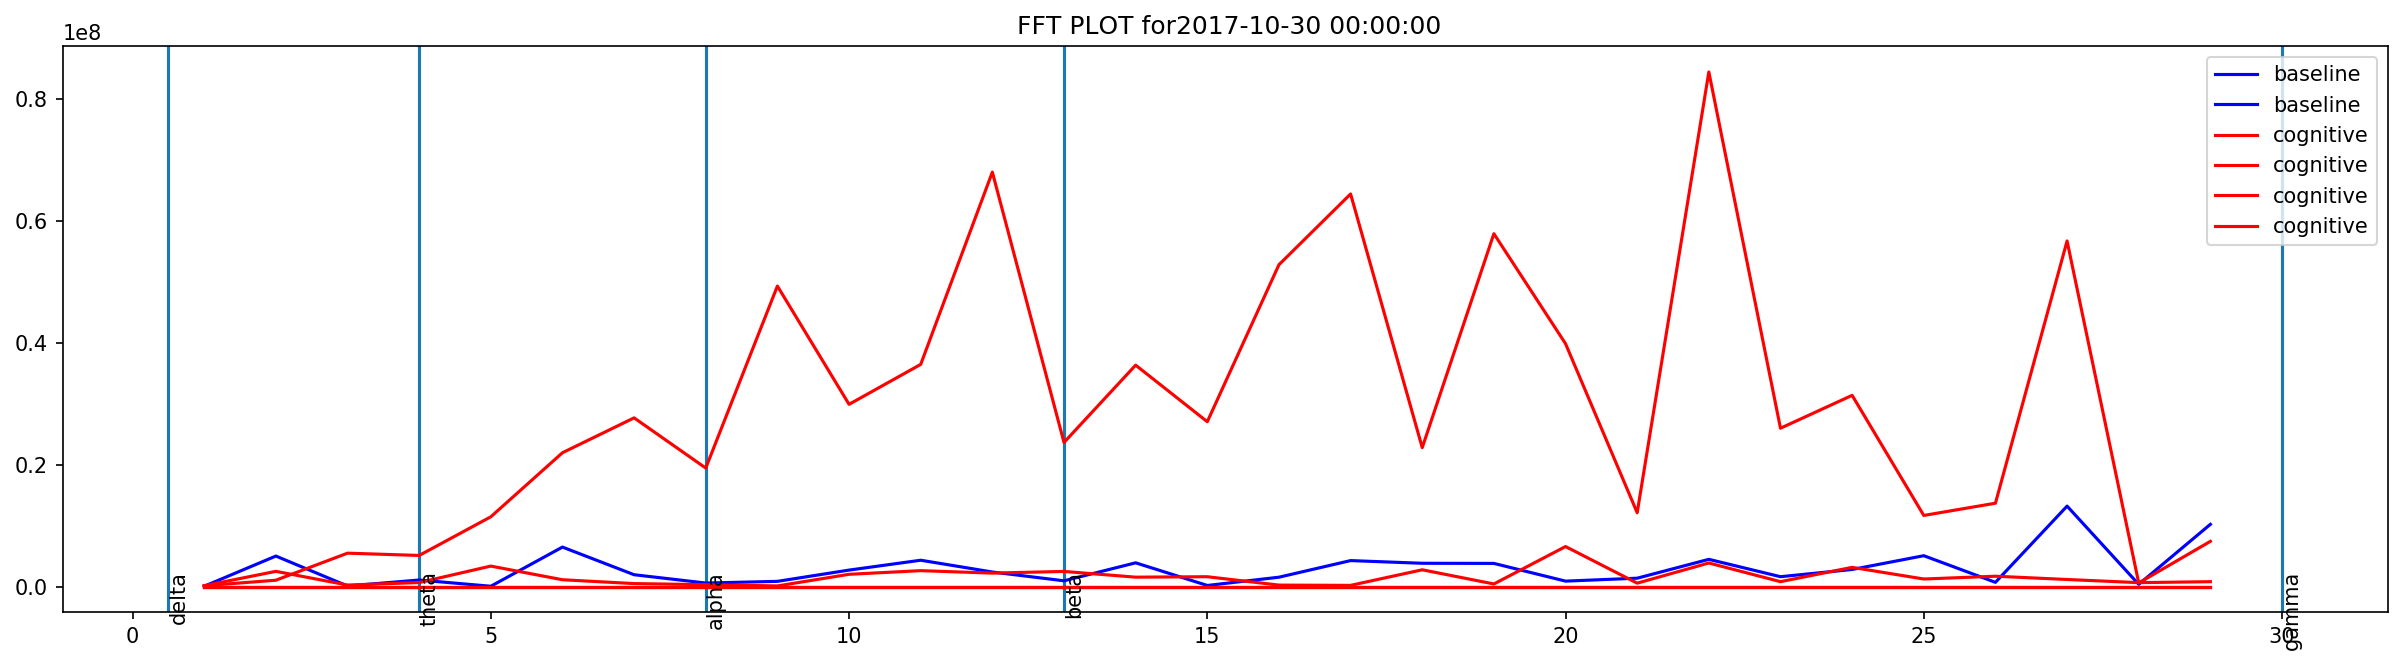

Date 2017-10-31 00:00:00


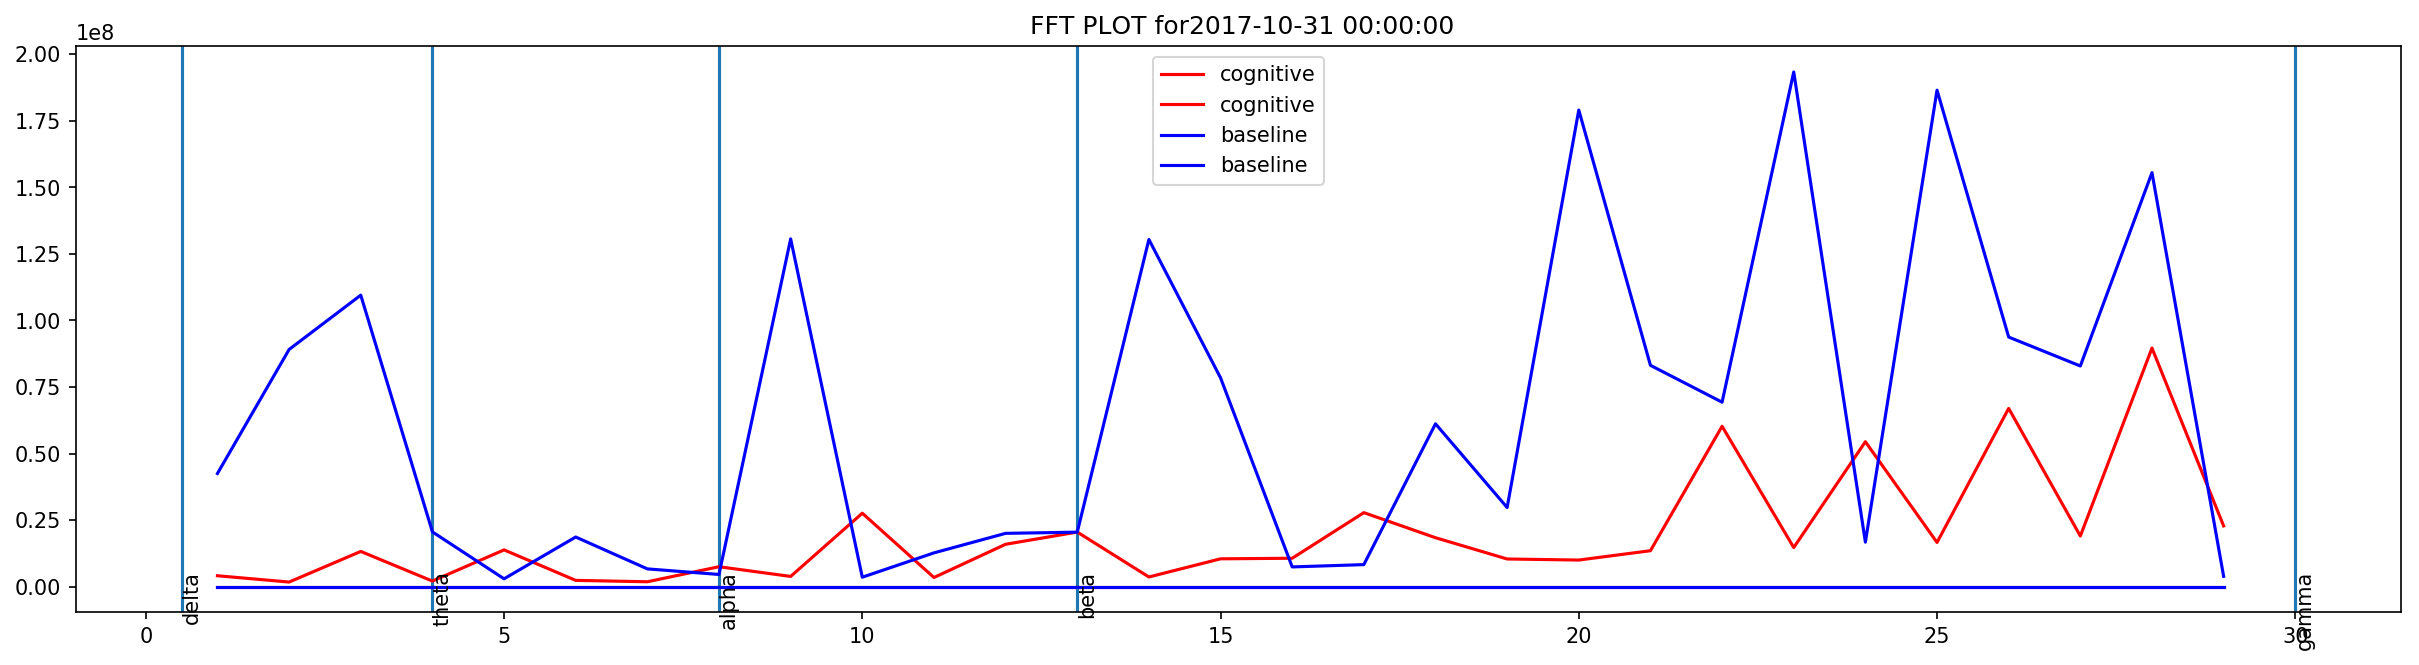

Date 2017-11-02 00:00:00


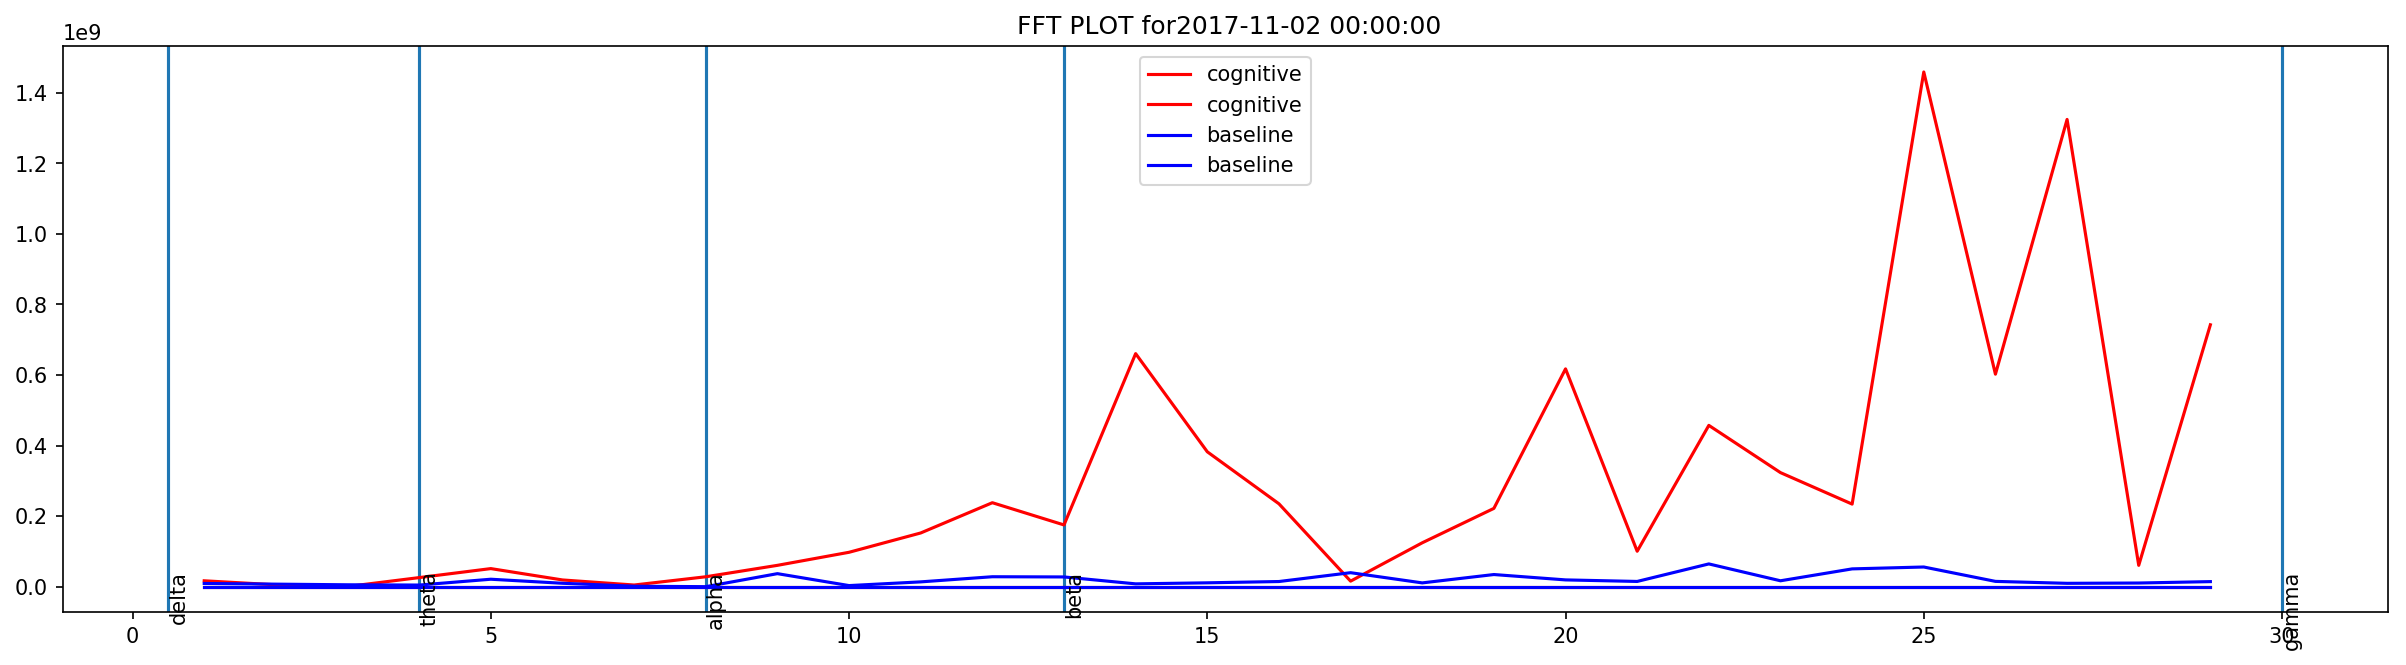

Date 2017-11-06 00:00:00


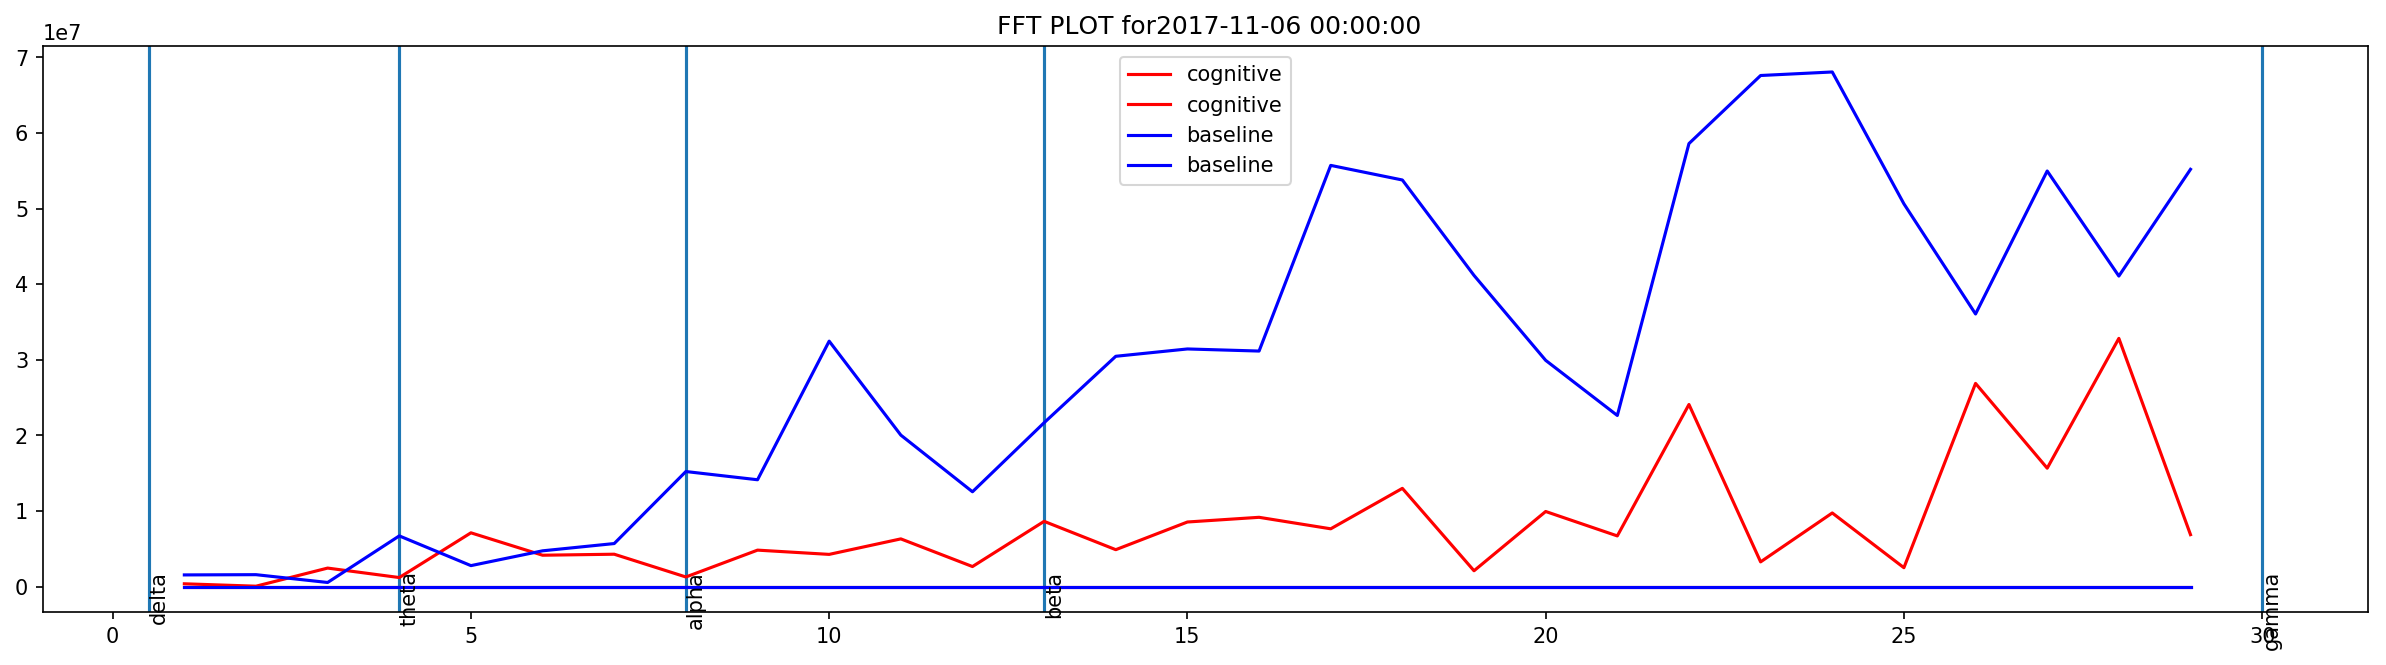

Date 2017-11-07 00:00:00


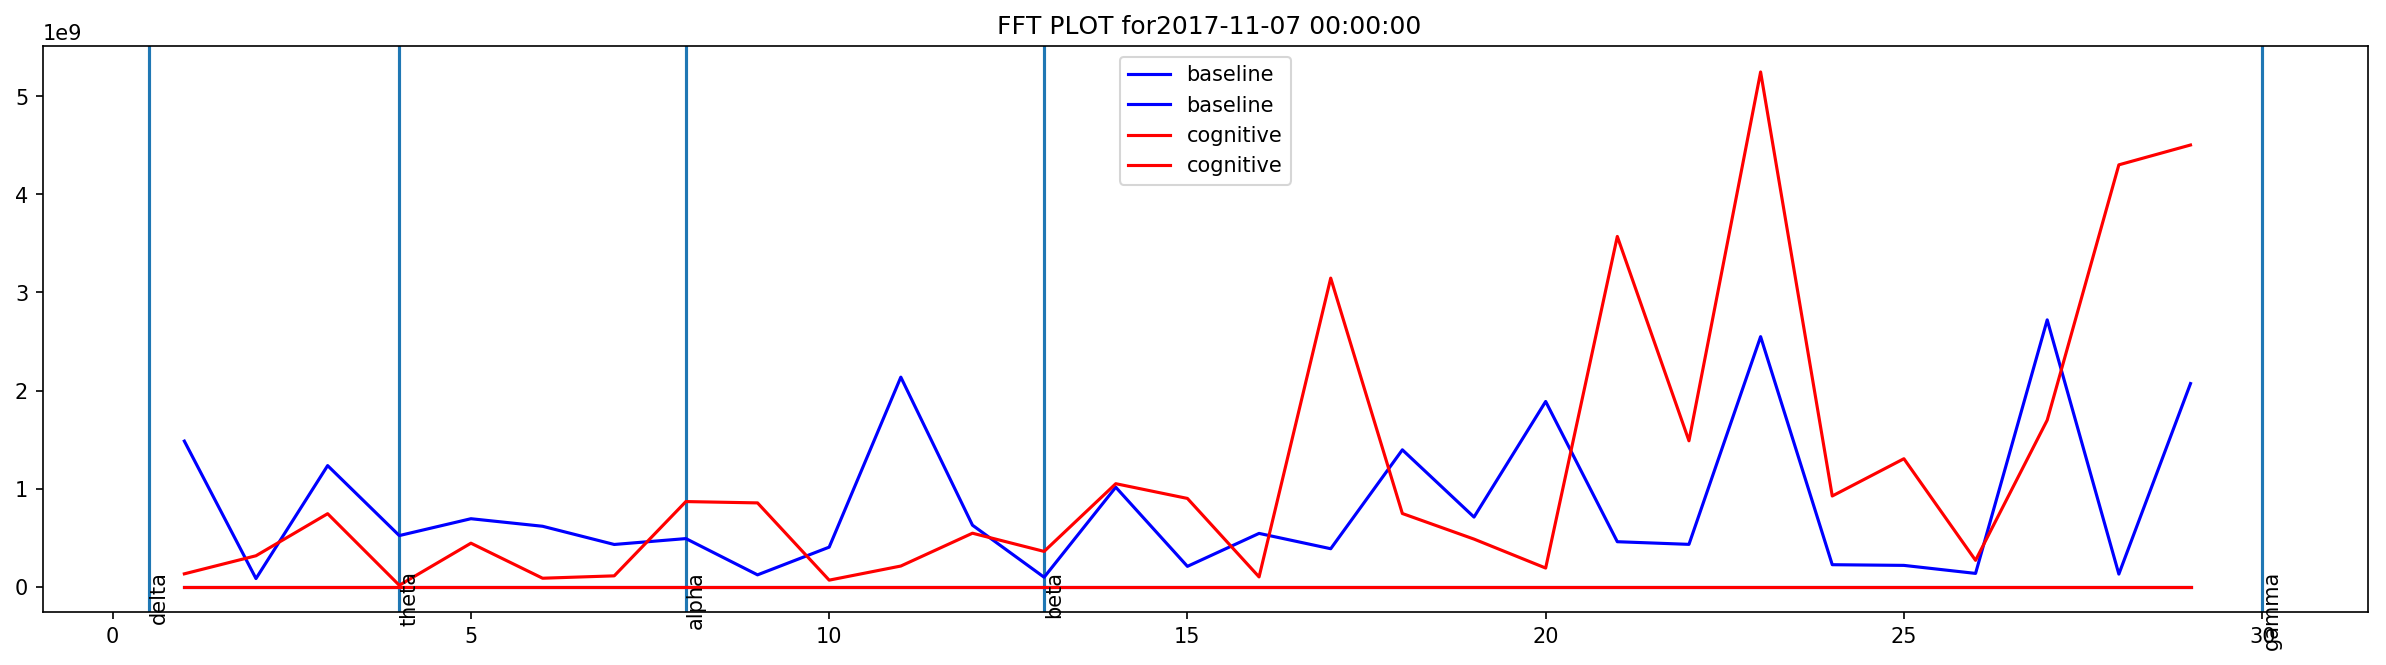

Date 2017-11-10 00:00:00


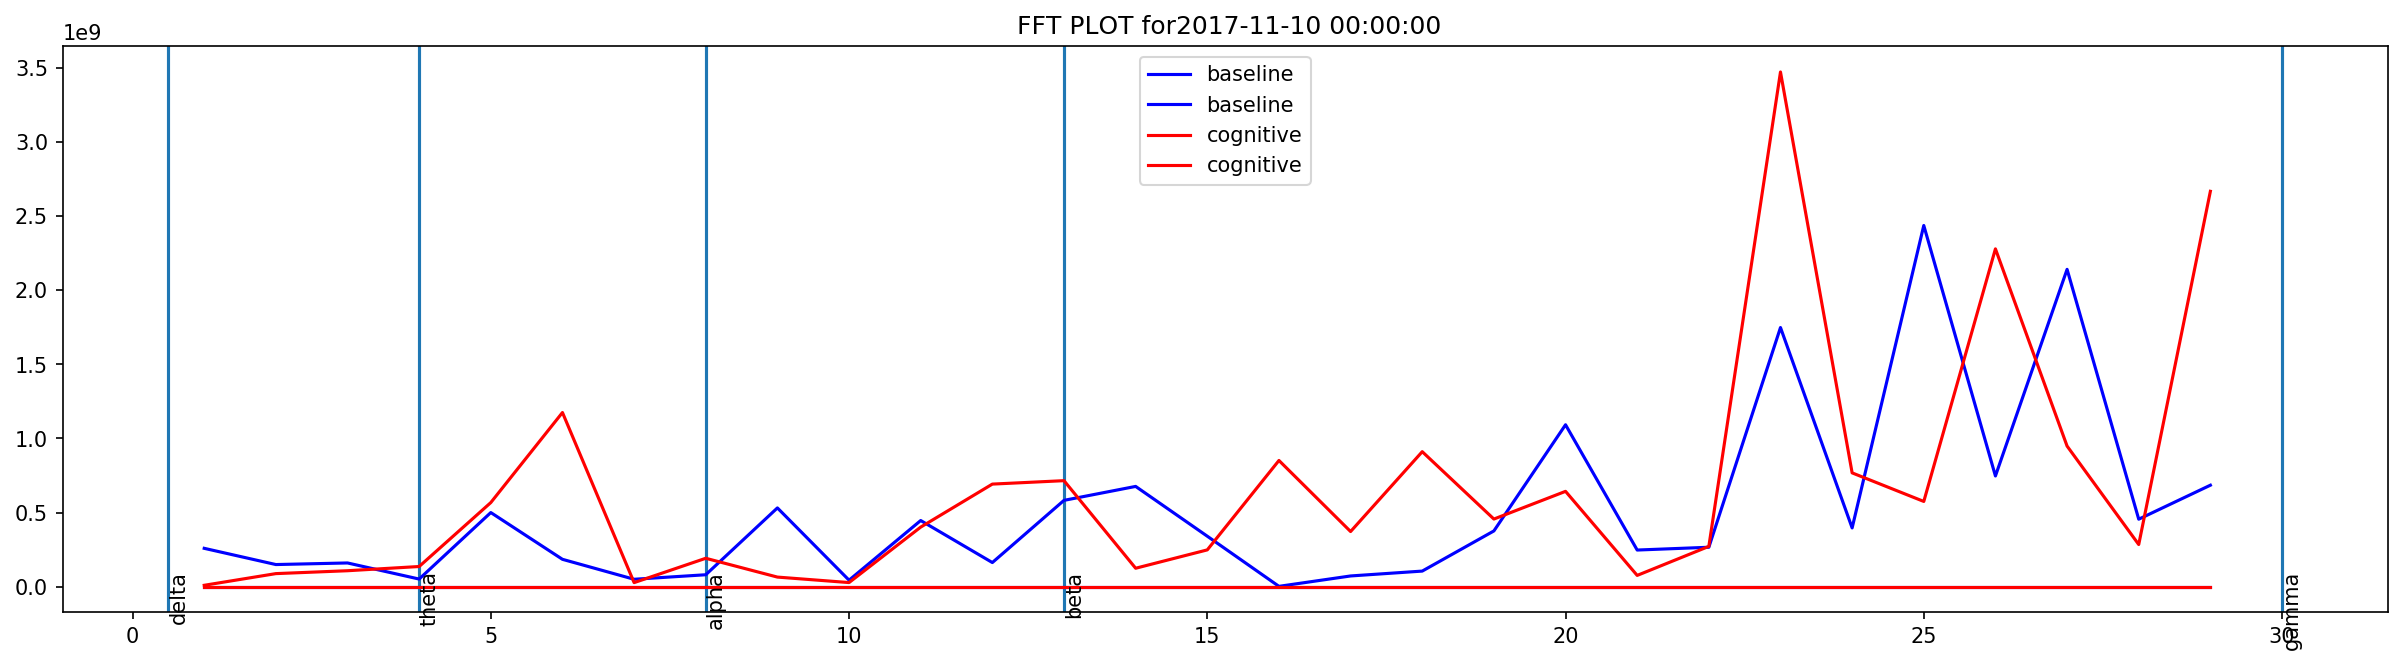

Date 2017-11-12 00:00:00


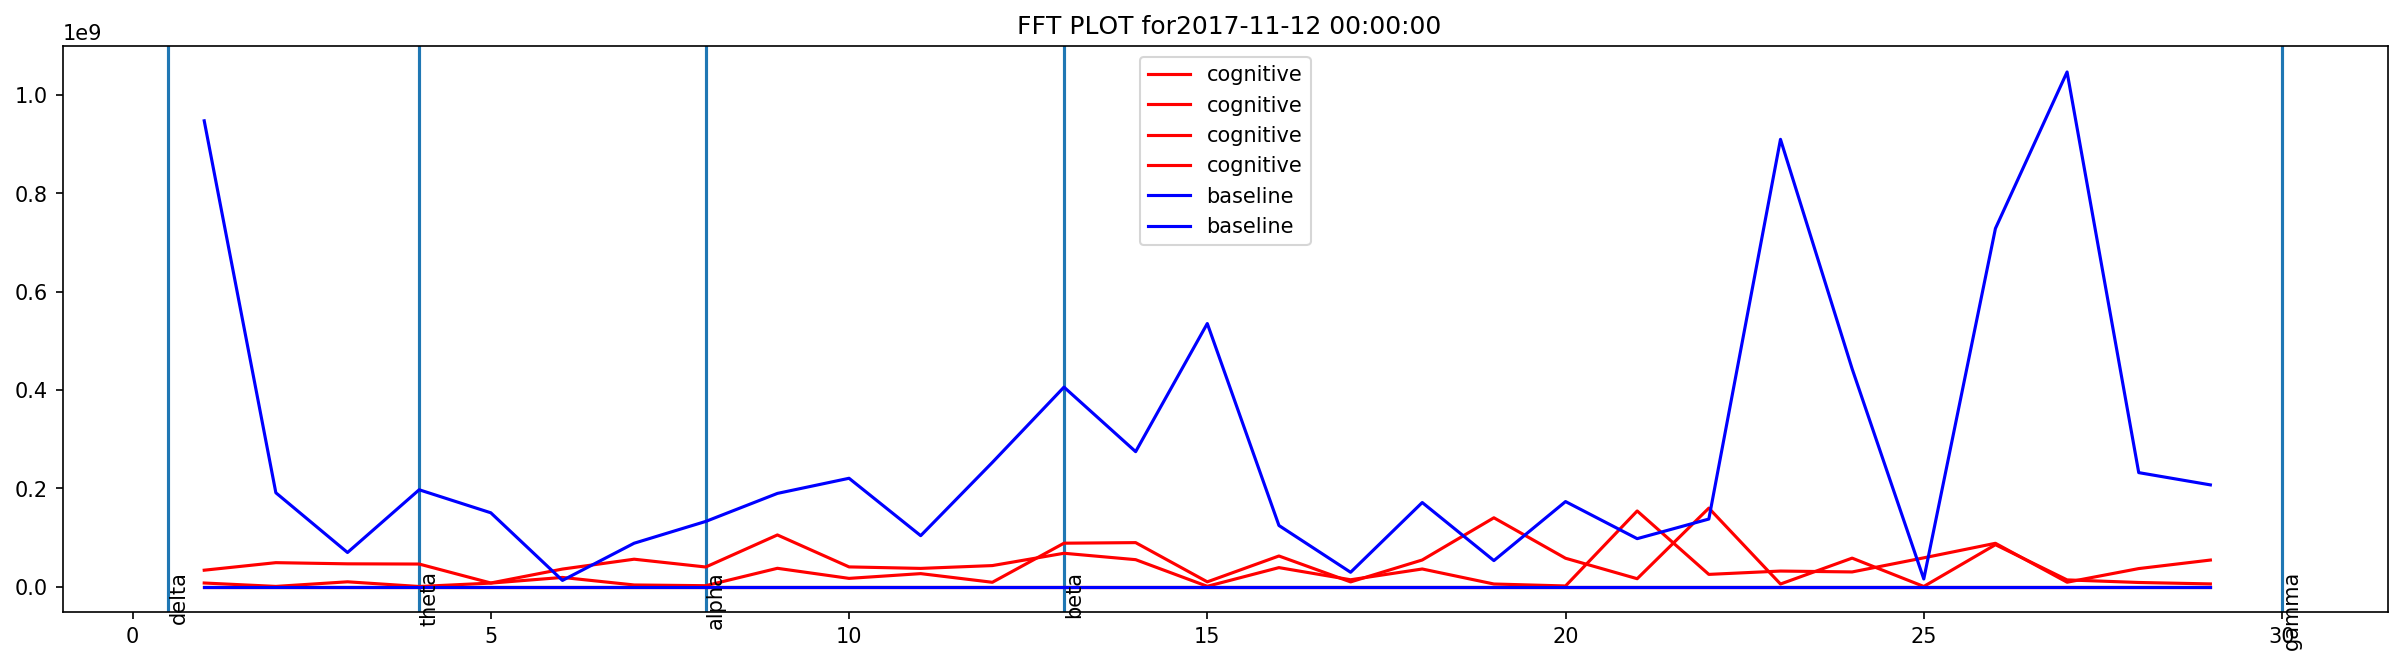

In [13]:
for date, group in dataset.groupby('date'): 
    print('Date', date)
#     print(type(date),type(group),group)
#     plot_eeg(group,date)
    plot_fft_eeg(group,date)


In [14]:
for date, group in dataset.groupby('date'): 
    print('Date', date)
#     print(type(date),type(group),group)


Date 2017-10-08 00:00:00
Date 2017-10-09 00:00:00
Date 2017-10-10 00:00:00
Date 2017-10-11 00:00:00
Date 2017-10-12 00:00:00
Date 2017-10-13 00:00:00
Date 2017-10-16 00:00:00
Date 2017-10-18 00:00:00
Date 2017-10-20 00:00:00
Date 2017-10-22 00:00:00
Date 2017-10-23 00:00:00
Date 2017-10-24 00:00:00
Date 2017-10-27 00:00:00
Date 2017-10-28 00:00:00
Date 2017-10-29 00:00:00
Date 2017-10-30 00:00:00
Date 2017-10-31 00:00:00
Date 2017-11-02 00:00:00
Date 2017-11-06 00:00:00
Date 2017-11-07 00:00:00
Date 2017-11-10 00:00:00
Date 2017-11-12 00:00:00


In [18]:
# s=np.array(sample)
# s=s.reshape(len(dataset),500)

In [17]:
# import numpy as np
# from sklearn.metrics.pairwise import cosine_similarity


# cosine_similarity(s[:5,:])

## Let's find the cosine similarity across dates for a particular task

In [19]:
dataset = pd.read_csv('all_data_labelled.csv')
dataset.eeg = dataset.eeg.map(json.loads)
dataset['date']=pd.to_datetime(dataset['date'])

dataset=dataset.sort_values(by='date')
def to_power_spectrum_df(raw_readings):
    '''
    Take raw voltages,
    transform into frequency domain,
    return a power spectrum.
    
    '''
    sampling_rate=len(raw_readings)
    # FFT the raw readings
    fftd = np.fft.fft(raw_readings)
    # take absolute value
    # producing a symmetrical power spectrum
    ps = np.abs(fftd)**2
    # since the power spectrum is symmetrical, 
    # take half
    half_len = len(ps)//2
    ps = ps[:half_len]
#     # we'll calculate the frequencies
    window_size = len(raw_readings)
    freqs = numpy.fft.fftfreq(window_size,d=1/sampling_rate)
#     # splitting that in half to match
    freqs = freqs[:half_len]
    power_spectrum = {
        'frequency (Hz)': freqs,
        'magnitude': ps,
    }
    return power_spectrum['magnitude']

In [20]:
# Here we are selecting 512 points from a random starting point

In [21]:
def pickup_random_sample(raw_reading):
    pick_len =1024 #length of chunk we want to choose
    total_len = len(raw_reading)
    start_pt = np.random.randint(total_len - pick_len)
    segment = raw_reading[start_pt:start_pt+pick_len]
    return to_power_spectrum_df(segment)

In [22]:
# dataset = pd.read_csv('all_data_labelled.csv')
# dataset.eeg = dataset.eeg.map(json.loads)

In [23]:
# lengths_of_eeg=dataset['eeg'].apply(lambda x:len(x))
# # min(lengths_of_eeg)
# rm=[i for i, j in enumerate(lengths_of_eeg) if j == 0]
# dataset=dataset.drop(dataset.index[[rm]])


In [24]:
dataset["segment"] = dataset.eeg.apply(pickup_random_sample)


In [32]:
dataset_baseline = dataset[dataset.task=="baseline"].copy(deep=True)
# all lumosity activities
dataset_cognitive = dataset[dataset.task=="cognitive"].copy(deep=True)

In [34]:
dataset_baseline = dataset_baseline.reset_index(drop=True)
dataset_cognitive = dataset_cognitive.reset_index(drop=True)


In [35]:
def get_cosine_similarity(a,b):
    a = np.array(a)
    b = np.array(b)
    return dot(a,b)/(norm(a)*norm(b))

In [36]:
date_list_baseline = dataset_baseline.date.tolist()
segments_list_baseline = dataset_baseline.segment.tolist()
phase_list_baseline=dataset_baseline.phase_distance.tolist()
phase_baseline=dataset_baseline.phase_no.tolist()

date_list_cognitive = dataset_cognitive.date.tolist()
segments_list_cognitive= dataset_cognitive.segment.tolist()
phase_list_cognitive=dataset_cognitive.phase_distance.tolist()
phase_cognitive=dataset_cognitive.phase_no.tolist()

In [37]:
baseline_comparisons = []
for segment1 in segments_list_baseline:
    curr_list = []
    for segment2 in segments_list_baseline:
        curr_list.append(get_cosine_similarity(segment1,segment2))
    baseline_comparisons.append(np.array(curr_list))
# baseline_comparisons

In [38]:
cognitive_comparisons = []
for segment1 in segments_list_cognitive:
    curr_list = []
    for segment2 in segments_list_cognitive:
        curr_list.append(get_cosine_similarity(segment1,segment2))
    cognitive_comparisons.append(np.array(curr_list))
    
# cognitive_comparisons

In [39]:
baseline_comparisons = np.array(baseline_comparisons)
cognitive_comparisons = np.array(cognitive_comparisons)

In [125]:


"""try to find relation nbetween baseline and cognitive task of the same day
use raw eeg data for this """

def pickup_random_eeg(raw_reading):
    pick_len =1024 #length of chunk we want to choose
    total_len = len(raw_reading)
    start_pt = np.random.randint(total_len - pick_len)
    segment = raw_reading[start_pt:start_pt+pick_len]
    return np.array(segment)
dataset["rawsegment"] = dataset.eeg.apply(pickup_random_eeg)


datelist_dif=[]
base_cog_list=[]
day_list=[]
AVG_BASELINE= dataset[dataset.task=="baseline"].rawsegment.mean()
for date, group in dataset.groupby('date'): 
   
    s=(group['task']).tolist()
    
#     print(s)
  
    if 'baseline'in s and 'cognitive'in s:
        print('Date', date)
        print('Both')
#         baseline = dataset[dataset.task=="baseline"].rawsegment.mean()
#         cognitive = dataset[dataset.task=="cognitive"].rawsegment.mean()
        baseline = group[group.task=="baseline"].rawsegment.mean()
        cognitive = group[group.task=="cognitive"].rawsegment.mean()
#         base_cog=baseline-cognitive
        base_cog=AVG_BASELINE-cognitive
      
        datelist_dif.append(date)
        base_cog_list.append(base_cog)
        day_list.append(group['phase_distance'].tolist()[0])
        
        
#         TRY AVERAGE BASELINE AND COG INDIVIDUAL


#         print(len(base_cog_list))
        

    else:
        print('Date', date)
        print('no************')
#     print(type(date),type(group),group)



base_cog_segments=np.array(base_cog_list)#.reshape(len(base_cog_list),512)
# base_cog_segments
base_cog_comparisons = []
for segment1 in base_cog_segments:
    curr_list = []
    for segment2 in base_cog_segments:
        curr_list.append(get_cosine_similarity(segment1,segment2))
#         print(curr_list)
    base_cog_comparisons.append(np.array(curr_list))
base_cog_comparisons

Date 2017-10-08 00:00:00
Both
Date 2017-10-09 00:00:00
Both
Date 2017-10-10 00:00:00
Both
Date 2017-10-11 00:00:00
Both
Date 2017-10-12 00:00:00
no************
Date 2017-10-13 00:00:00
Both
Date 2017-10-16 00:00:00
Both
Date 2017-10-18 00:00:00
Both
Date 2017-10-20 00:00:00
Both
Date 2017-10-22 00:00:00
Both
Date 2017-10-23 00:00:00
no************
Date 2017-10-24 00:00:00
Both
Date 2017-10-27 00:00:00
Both
Date 2017-10-28 00:00:00
Both
Date 2017-10-29 00:00:00
Both
Date 2017-10-30 00:00:00
Both
Date 2017-10-31 00:00:00
Both
Date 2017-11-02 00:00:00
Both
Date 2017-11-06 00:00:00
Both
Date 2017-11-07 00:00:00
Both
Date 2017-11-10 00:00:00
Both
Date 2017-11-12 00:00:00
Both


[array([ 1.        ,  0.13848458,  0.24262394,  0.15935213,  0.3678083 ,
         0.26365463,  0.09682851,  0.18082509,  0.31063622,  0.26481667,
         0.17359466,  0.27220175,  0.11876759,  0.33857665,  0.26354246,
         0.07806517,  0.34097181,  0.08326783,  0.10948314,  0.25342072]),
 array([ 0.13848458,  1.        ,  0.04826205,  0.15464581,  0.29015756,
         0.19803844,  0.05552387,  0.17927073,  0.25399581,  0.258456  ,
         0.15925605,  0.2375691 ,  0.1142454 ,  0.27032128,  0.27131052,
         0.07416752,  0.2306492 ,  0.03267421,  0.15141994,  0.17801531]),
 array([ 0.24262394,  0.04826205,  1.        ,  0.10933782,  0.3886057 ,
         0.334815  ,  0.04035793,  0.09891348,  0.36635367,  0.28434586,
         0.19515761,  0.36038782,  0.17407205,  0.34689904,  0.31770914,
         0.08447948,  0.35050867,  0.06267785,  0.18220771,  0.36049708]),
 array([ 0.15935213,  0.15464581,  0.10933782,  1.        ,  0.27518814,
         0.2385166 ,  0.05778532,  0.16768333

In [179]:
def plot_date_similarity(comparisons, date_list, task):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cmap = cm.get_cmap('jet', 30)
#     cax = ax.matshow(comparisons, vmin=-1, vmax=1)
    cax = ax.imshow(comparisons, interpolation="nearest", cmap=cmap)
#     ax.grid(True)
    ticks = numpy.arange(0,len(date_list),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(date_list,rotation='vertical',fontsize=14)
    ax.set_yticklabels(date_list,fontsize=14)
    plt.title("Cosine Similarity of "+ task+" task across different days",fontsize=18)
    plt.colorbar(cax, ticks=[0,.2,.4,.6,.8,1])
    plt.show()
    
    
    # fig, axes = plt.subplots(1, 1, figsize=(16, 9))

def plot_phase(comparisons,dates,text):
    color=['red','blue','yellow','green']

    fig, axes = plt.subplots(1, 1, figsize=(16, 7))
    for i in range(len(comparisons)):
        axes.plot(comparisons[i],c=color[dates[i]-1],label=dates[i])
    axes.set_xticklabels(dates)
    plt.xticks(rotation=25)
    plt.xticks(np.arange(0, len(dates), 1.0))
    plt.legend(bbox_to_anchor=(1.0, 1.05))
    plt.title("Cosine Similarity of "+text+" task across different phases",fontsize=18)
    plt.show()



    
    
    


In [88]:
baseline_comparisons.shape

(23, 23)

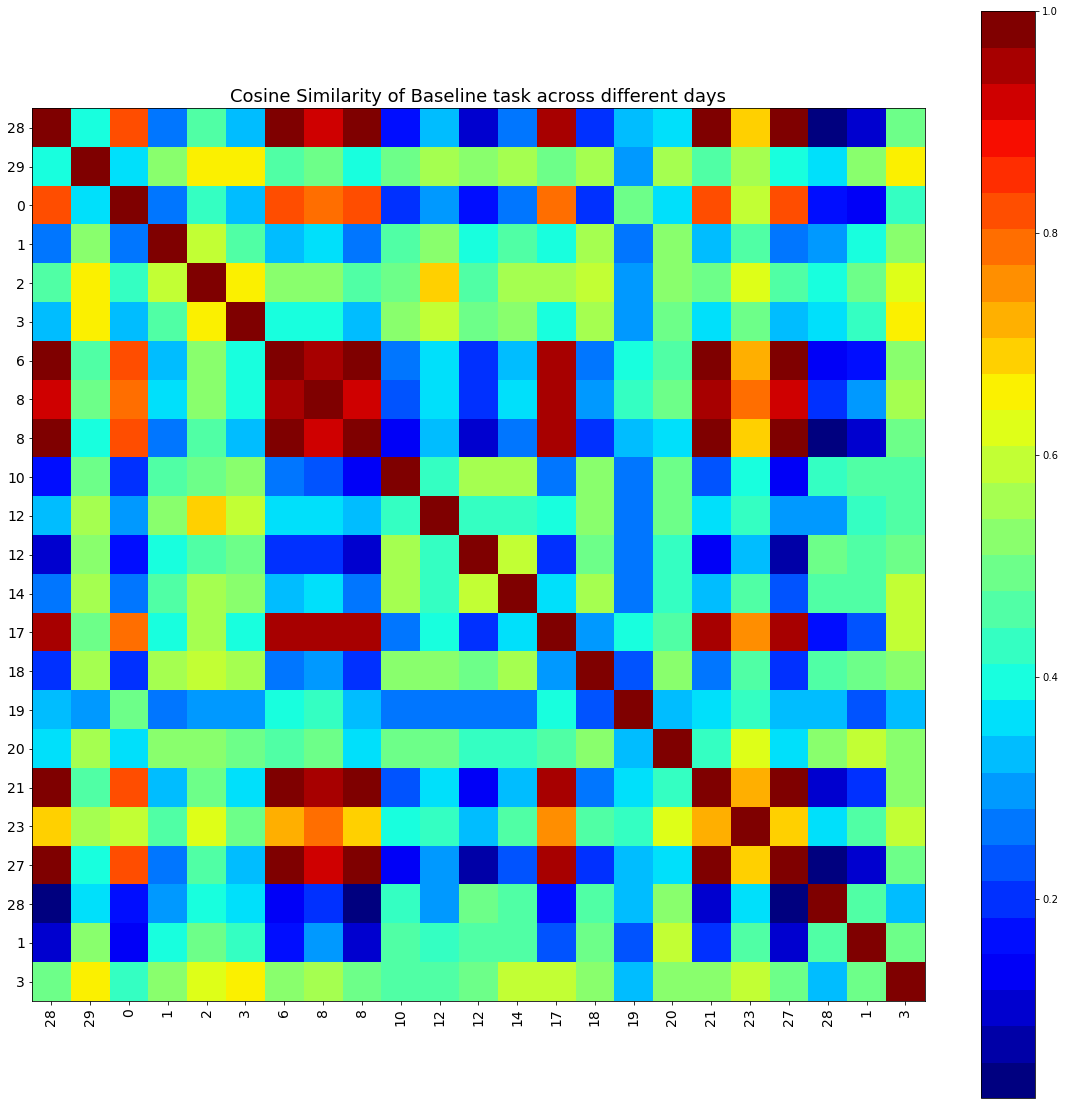

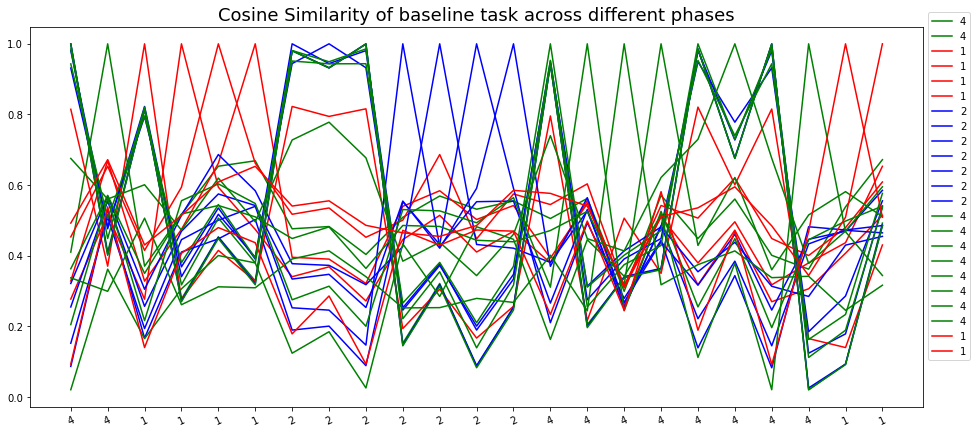

In [184]:
plot_date_similarity(baseline_comparisons, phase_list_baseline, "Baseline")
plot(baseline_comparisons,phase_baseline,'baseline')

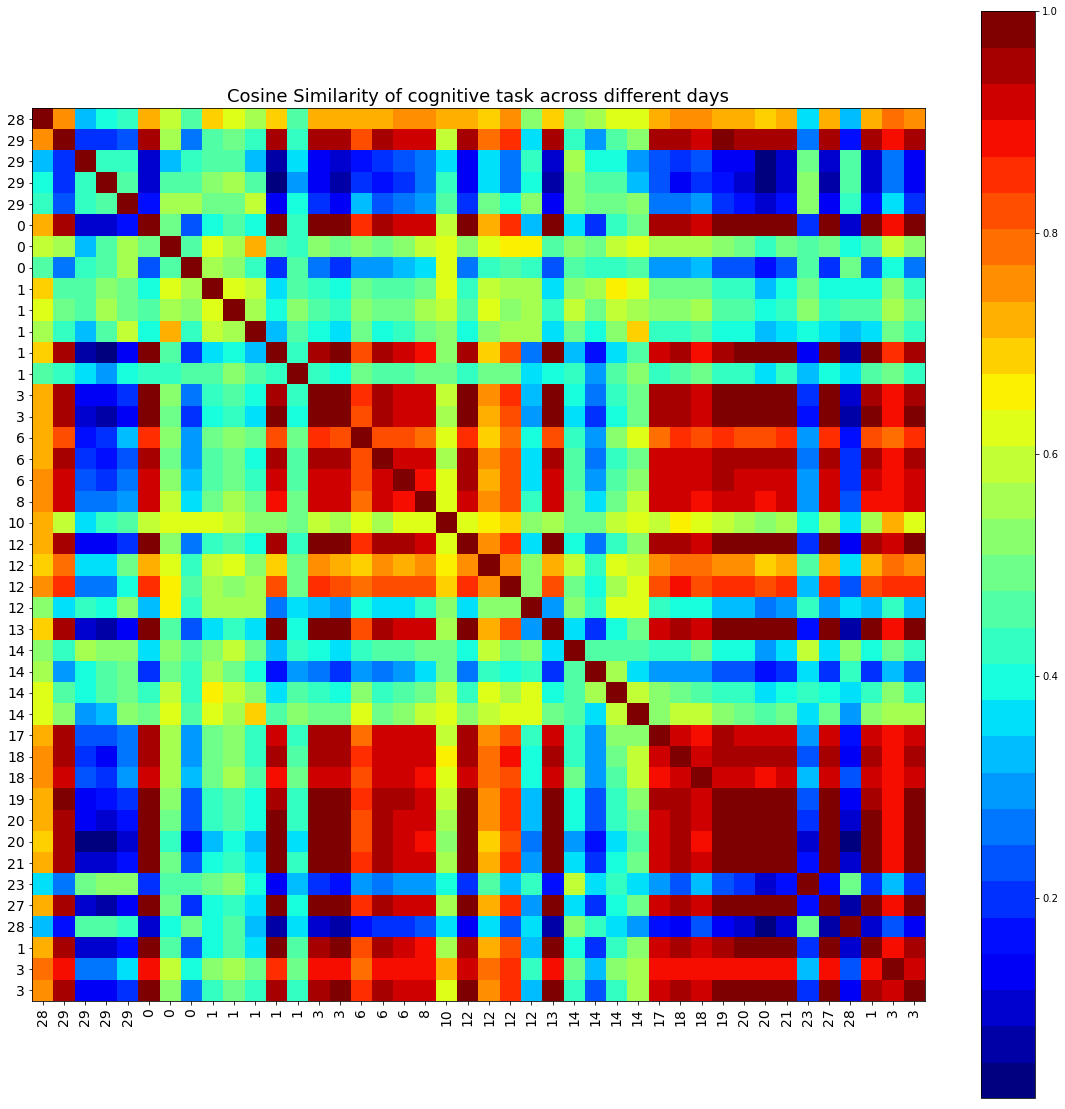

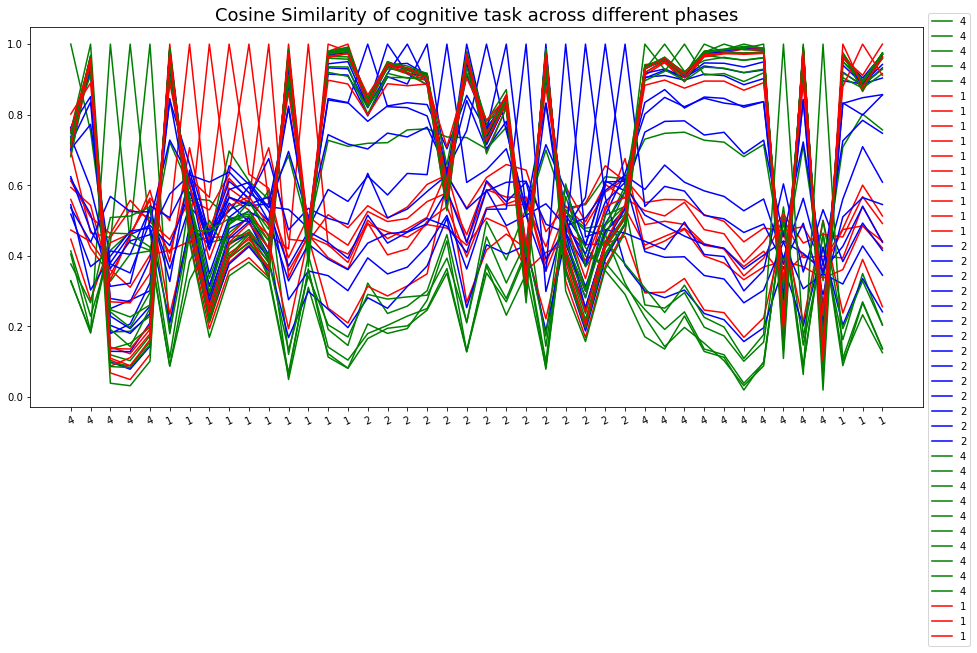

In [185]:
plot_date_similarity(cognitive_comparisons, phase_list_cognitive, "cognitive")
plot(cognitive_comparisons, phase_cognitive, "cognitive")

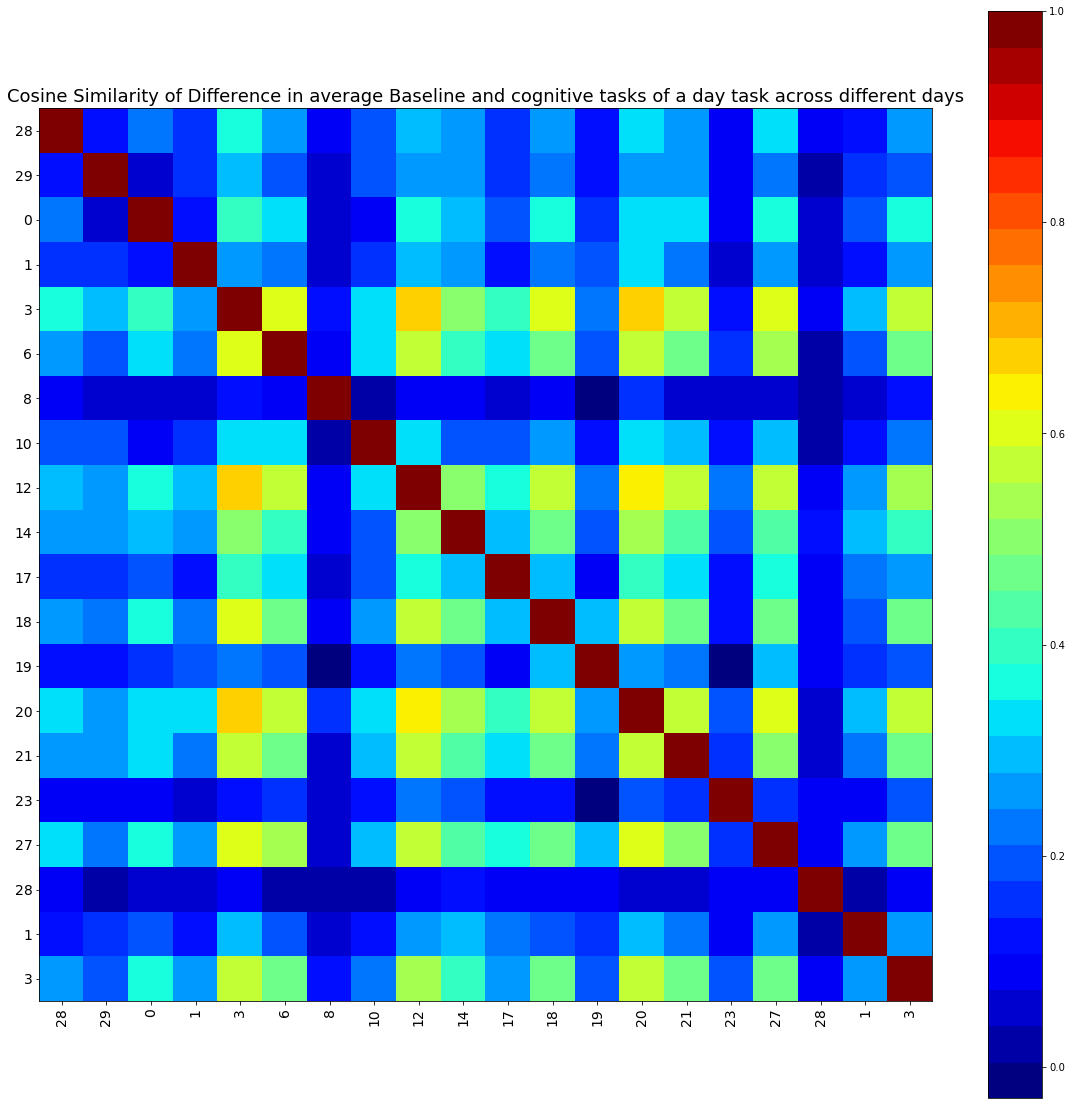

IndexError: list index out of range

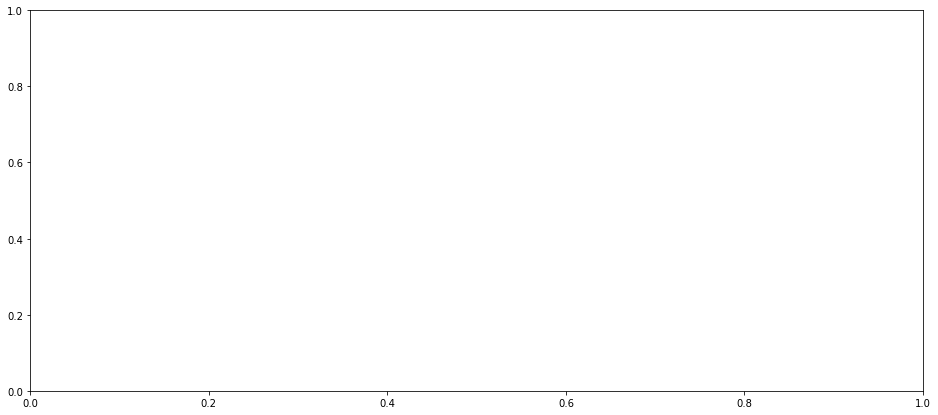

In [182]:
plot_date_similarity(base_cog_comparisons,day_list, "Difference in average Baseline and cognitive tasks of a day")
plot(base_cog_comparisons,day_list, "Difference in average Baseline and cognitive tasks of a day")

In [ ]:
def plot_date_similarity_lines(comparisons, date_list, task):
    fig = plt.figure(figsize=(18,5))
    ax = fig.add_subplot(111)
    cax = ax.plot(comparisons[0])
    ticks = numpy.arange(0,len(date_list),1)
    ax.set_xticks(ticks)
#     ax.set_yticks(ticks)
    ax.set_xticklabels(date_list)
#     ax.set_yticklabels(date_list)
    plt.title("Cosine Similarity of "+str(date_list[0])+ task+" task across different days")
    plt.show()

In [ ]:
plot_date_similarity_lines(cognitive_comparisons, date_list_cognitive, "cognitive")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.metrics import confusion_matrix
# mat = confusion_matrix(digits.target, labels)
date_list=str(date_list_cognitive)
sns.heatmap(cognitive_comparisons, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=date_list,
            yticklabels=date_list)

plt.xlabel('true label')
plt.ylabel('predicted label');

